# Homework #6 (Due 10/22/2020, 11:59pm)
## Descent Algorithms for Optimization

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2020**

**Name:** Assaraf David

**Students collaborators:** Ancel Gael, Pellegrin Raphael

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Problem Description: Minimizing the Cost of a Construction Project

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by

$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$

Read the data contained in `HW6_data.csv`. This is a set of coordinates $\{(x_n, y_n)\}$ configured on the curve $y^2 - x^2 = -0.1$. In this problem, we find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset of coordinates $(x_n, y_n)$.

### Part I: Cost minimization with descent algorithms

1. (**Visualizing the Optimization Landscape**) Using level curves (see Lab #1) and a 3D plot, visually verify that at $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is globally minimized.<br><br>

2. (**Gradient Descent**) Implement gradient descent for minimizing the **average** of $L$ over the locations given in the data, using the learning rate of 1.0 and initialization of $\lambda_1 = 2, \lambda_2 = 1$. Visually determine if your algorithm has converged. 

  **Hint:** You may need to visualize the behavior over the total number of iterations as well as its value over the last couple of hundreds of iterations to check for convergence.<br><br>

3. (**Stochastic Gradient Descent**) Implement stochastic gradient descent for minimizing the **average** of $L$ over the locations in the mini-batch, using the learning rate of 1.0 and initialization of $\lambda_1 = 2, \lambda_2 = 1$ and mini-batch size of 1. Visually determine if your algorithm has converged.

  **Hint:** You may need to visualize the behavior over the total number of iterations as well as its value over the last couple of hundreds of iterations to check for convergence.<br><br>

4. (**How to Compare GD and SGD Fairly**) Argue that minimizing the average loss over the locations is equivalent to minimizing the net loss. However, minimizing the average loss makes it possible to compare gradient descent and stochastic gradient descent on equal terms. Explain why this is true.<br><br>

5. (**Comparing the Efficiency of GD and SGD**) Compute the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.

  Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (in this case, you know the true global optima so you can check the norm $\|(\lambda_1, \lambda_2) - (\lambda_1^{\text{true}}, \lambda_2^{\text{true}})\|_2$ ). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.<br><br>

6. (**Comparing Sensitivity of GD and SGD to Learning Rate**) Compare the performance of both gradient descent methods for the following learning rates: 1000, 100, 1., 0.1. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of each algorithm. In particular, which algorithm is more sensitve to the learning rate?

  **Hint:** You may need to visualize the behavior over the total number of iterations as well as its value over the first and last couple of hundreds of iterations separately to isolate trends.<br><br>


7. (**Comparing Sensitivity of GD and SGD to Initialization**) Document the behaviour of your two descent algorithms for the following starting points, and for stepsizes of 10 and 50:
  - $(\lambda_1, \lambda_2) = (-2.47865, 0)$
  - $(\lambda_1, \lambda_2) = (-3, 0)$
  - $(\lambda_1, \lambda_2) = (-5, 0)$
  - $(\lambda_1, \lambda_2) = (-10, 0)$

  Based on your visualization of the graph/contour map of the lost function as well as the visualization of the loss function during descent, explain what is happening to your descent algorithms for each initialization.

#### 0. Load the data, definition of the cost function and gradient computation

Let us check the consistency of the data, ie if the points $(x, y)$ are located in the hyperbole $y^2 - x^2 = -0.1$.

In [2]:
data = pd.read_csv('HW6_data-1.csv', sep=',', header=None).T
data.columns = ['x', 'y']
data['eq'] = data['y']**2-data['x']**2
display(data.head(5))

,x,y,eq
0,17.218862,-17.215958,-0.1
1,20.838999,20.836600,-0.1
2,11.968430,11.964252,-0.1
3,80.804795,80.804176,-0.1
4,83.848662,83.848066,-0.1


In [29]:
lambda_1objective = 2.05384
lambda_2objective = 0
optimal_weight = np.asarray([lambda_1objective, lambda_2objective])

In [4]:
def l(x, y, lambda1, lambda2):
    lambda1_squared = lambda1**2
    lambda2_squared = lambda2**2
    """Computes the function depending on (x, y, lambda1, lambda2)
    Please note that we have directly substituted the value of y**2 - x**2 by -0.1"""
    return 0.000045*lambda2_squared*y-0.000098*lambda1_squared*x+0.003926*lambda1*x*np.exp(-0.1*(lambda1_squared+lambda2_squared))

In [5]:
def L(lambda1, lambda2):
    """Computes the average of l(x, y, lambda1, lambda2) with all the points (x,y) defined in the dataframe"""
    return np.mean(l(data['x'].values, data['y'].values, lambda1, lambda2))

##### Gradient computation for L

$$
L(\lambda_1, \lambda_2) = \sum_{n=1}^N{0.000045\lambda_2^2 y_n - 0.000098\lambda_1^2 x_n + 0.003926\lambda_1 x_n\exp{[(y_n^2 - x_n^2)(\lambda_1^2 + \lambda_2^2)]}}
$$
$$
\nabla L(\lambda_1, \lambda_2) = \begin{bmatrix}
                                    \frac{\partial L}{\partial \lambda_1}\\
                                    \frac{\partial L}{\partial \lambda_2}\\
                                 \end{bmatrix}
$$
$$
\nabla L(\lambda_1, \lambda_2) = \begin{bmatrix}
                                    \sum_{n=1}^N{-0.000196\lambda_1x_n + [0.003926x_n+0.007852\lambda_1^2x_n(y_n^2 - x_n^2)]\exp{[(y_n^2 - x_n^2)(\lambda_1^2 + \lambda_2^2)]}}\\
                                    \sum_{n=1}^N{0.000090\lambda_2y_n + 0.007852\lambda_1\lambda_2x_n(y_n^2 - x_n^2)\exp{[(y_n^2 - x_n^2)(\lambda_1^2 + \lambda_2^2)]}}\\
                                 \end{bmatrix}
$$

In [6]:
def aux(x, y, lambda1, lambda2):
    lambda1_squared = lambda1**2
    lambda2_squared = lambda2**2
    partial1 = -0.000196*lambda1*x+0.003926*x*np.exp(-0.1*(lambda1_squared+lambda2_squared))-0.0007852*lambda1_squared*x*np.exp(-0.1*(lambda1_squared+lambda2_squared))
    partial2 = 0.000090*lambda2*y-0.0007852*lambda1*lambda2*x*np.exp(-0.1*(lambda1_squared+lambda2_squared))
    return np.array([partial1, partial2]).T

In [7]:
def grad(lambda1, lambda2):
    return np.mean(aux(data['x'].values, data['y'].values, lambda1, lambda2), axis=0)

#### 1. Visualizing the Optimization Landscape

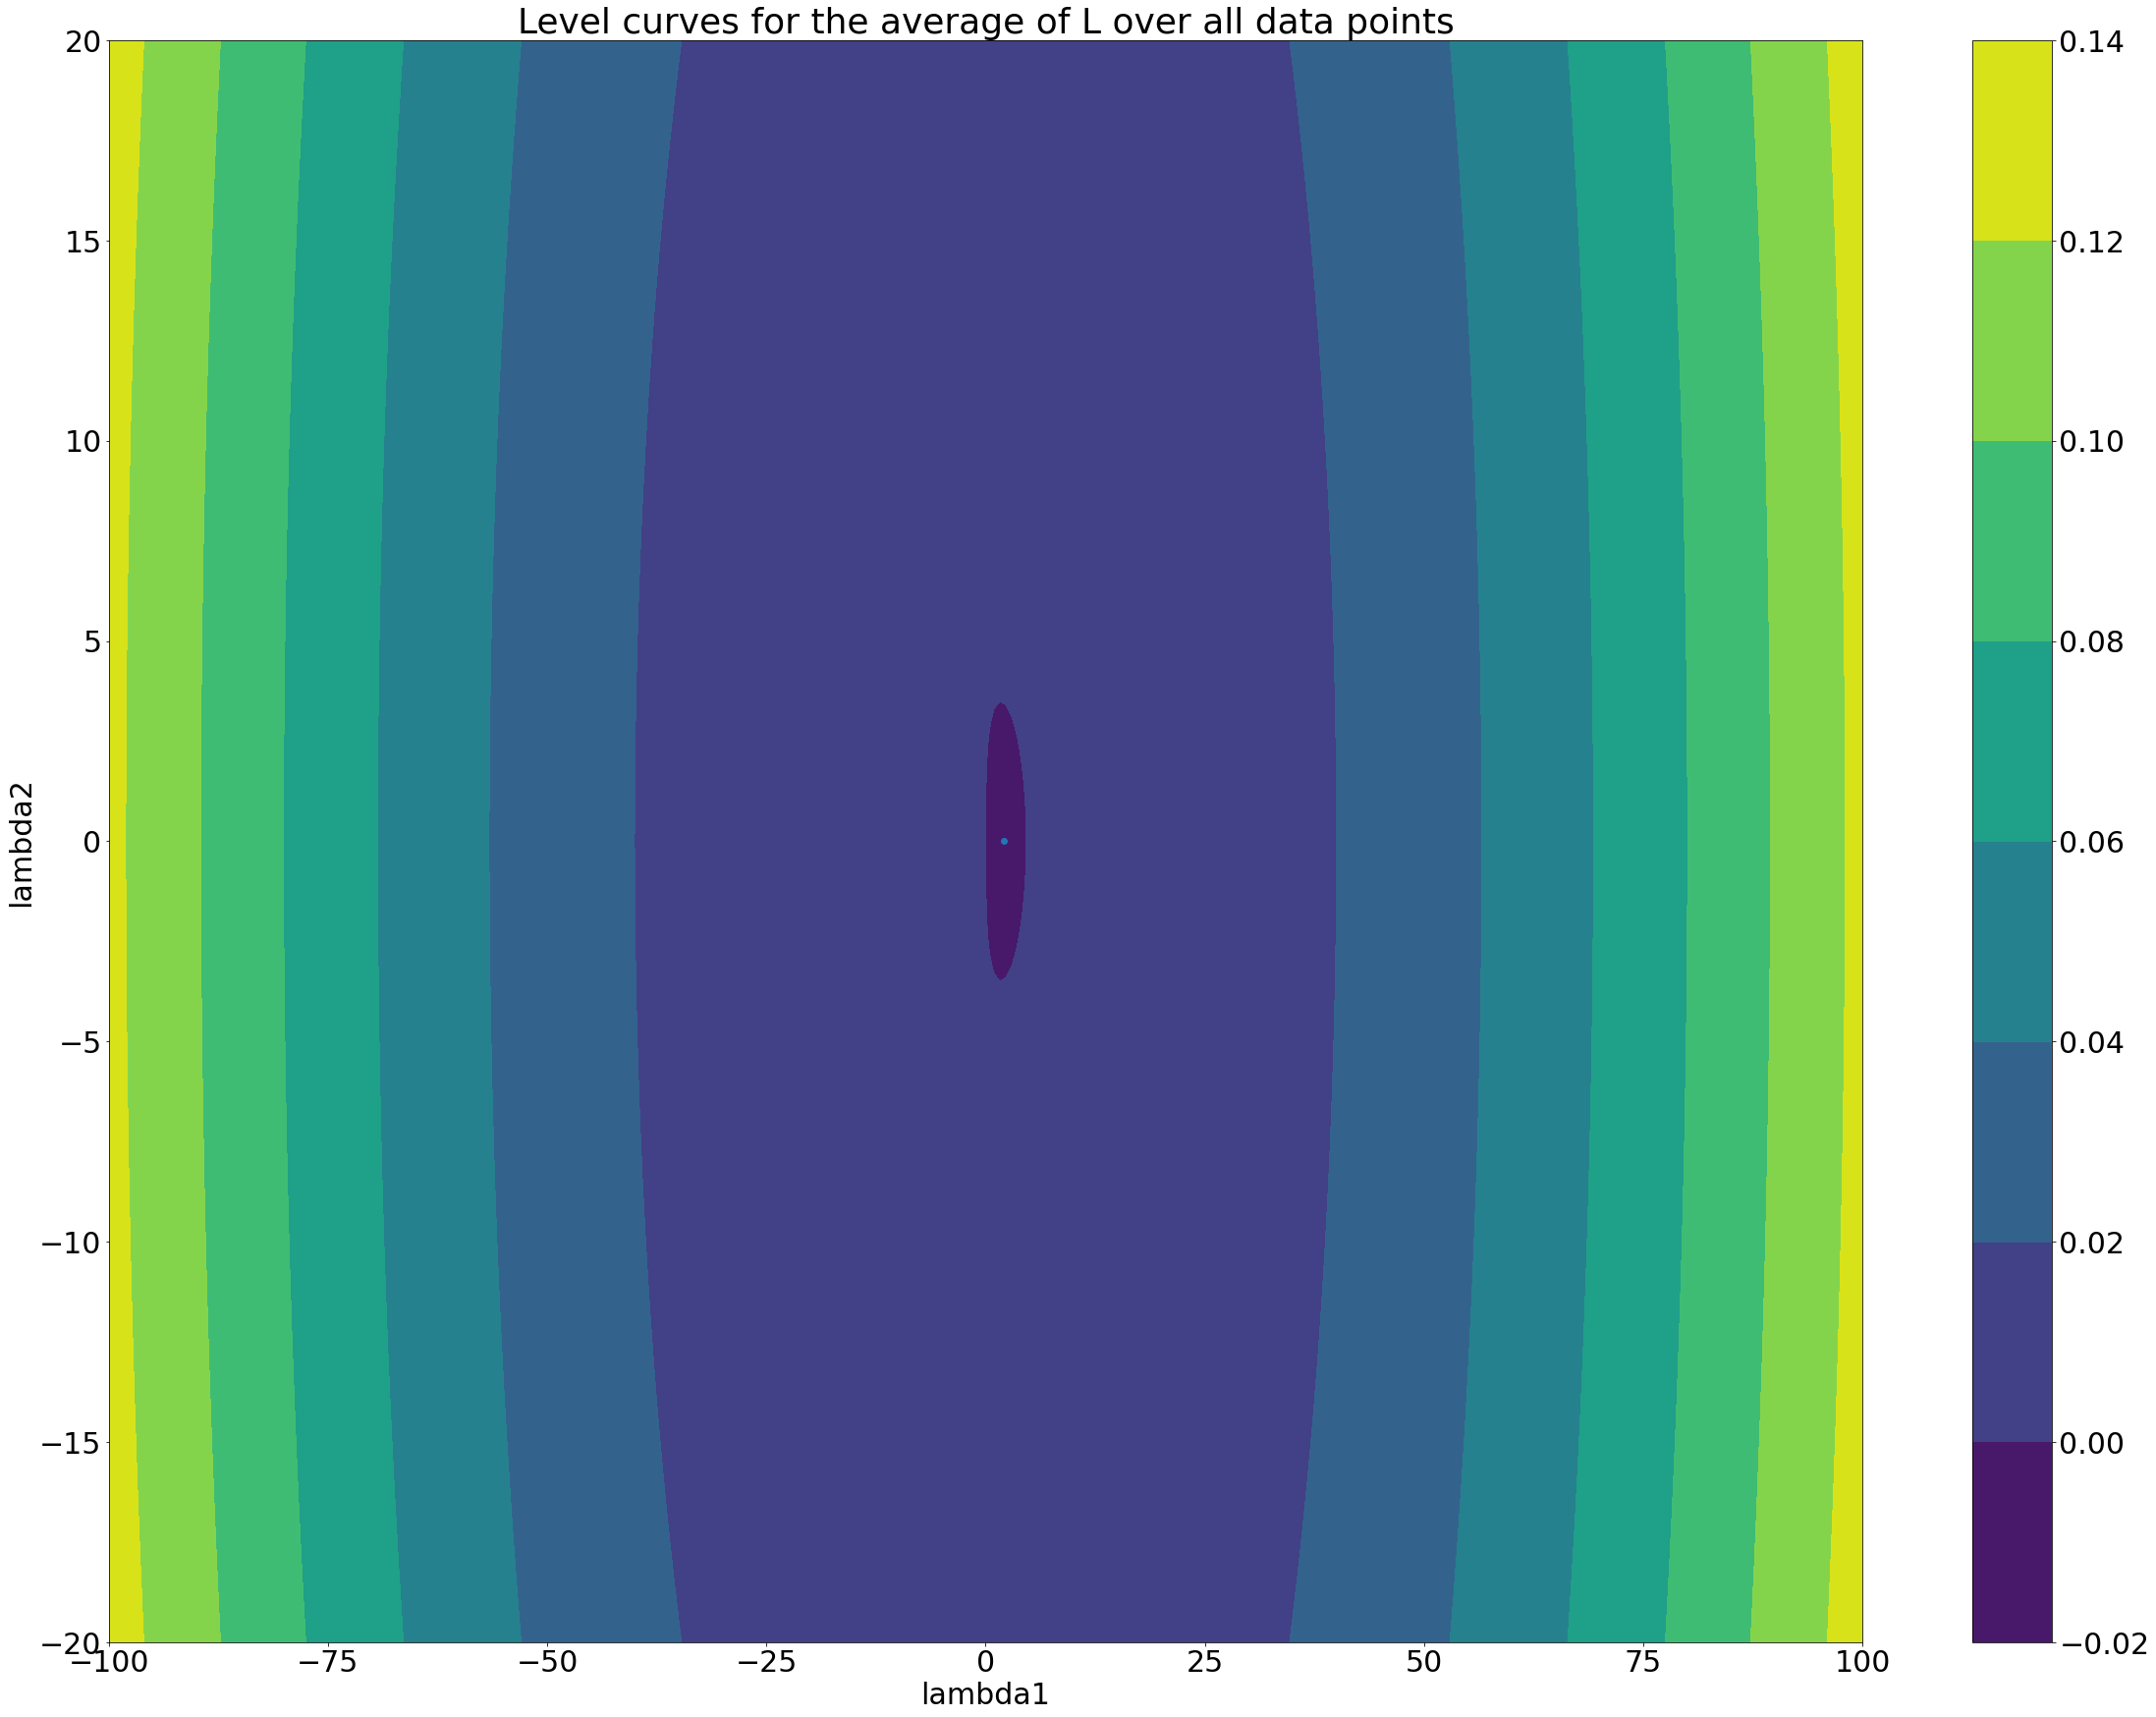

In [93]:
x_ax=np.linspace(-100,100,300)
y_ax=np.linspace(-20,20,300)
X_p, Y_p, Z_p=np.zeros((300,300)), np.zeros((300,300)), np.zeros((300,300))
for i in range(300):
    for j in range(300):
        Z_p[i][j]=L(x_ax[i],y_ax[j])
        X_p[i][j]=x_ax[i]
        Y_p[i][j]=y_ax[j]
fig,ax=plt.subplots(1,1)
fig.set_figheight(30)
fig.set_figwidth(40)
cp = ax.contourf(X_p,Y_p,Z_p)
fig.colorbar(cp) 
ax.set_title('Level curves for the average of L over all data points')
ax.set_xlabel('lambda1')
ax.set_ylabel('lambda2')
ax.scatter(2.05384,0)
plt.show()

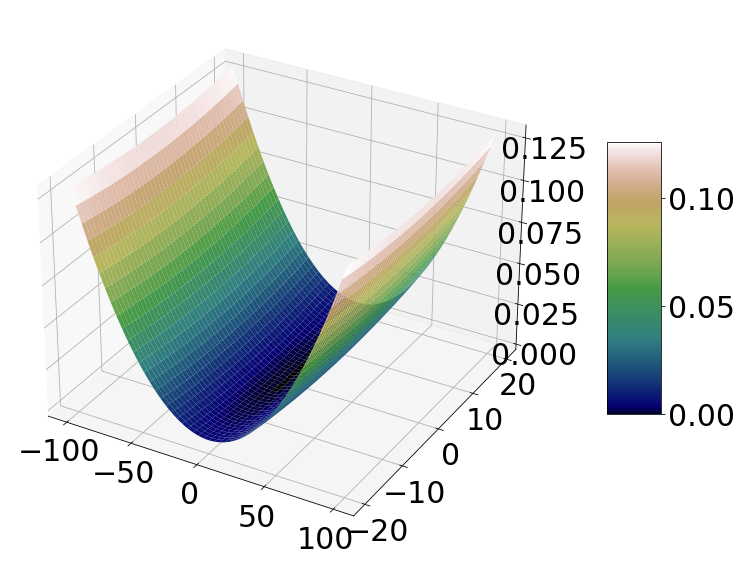

In [95]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
mycmap = plt.get_cmap('gist_earth')
pl=ax.plot_surface(X_p, Y_p, Z_p, cmap=mycmap)
fig.colorbar(pl, ax=ax, shrink=0.5, aspect=5)
plt.show()

#### 2. Gradient Descent of the average of $L$ accross the locations

In [96]:
def gradient_descent(gradient, function, learning_rate, stopping_condition_fn, initial_parameter, max_iter):  # try to make it generic
    initial_weight = initial_parameter
    function_values = []
    gradient_values = []
    weights = [initial_weight]
    iteration = 0
    while not stopping_condition_fn(weights, function_values, gradient_values, iteration, max_iter):
        grad = gradient(*weights[-1])
        gradient_values.append(grad)
        new_weight = weights[-1] - learning_rate*grad
        weights.append(new_weight)
        function_values.append(function(*weights[-1]))
        iteration += 1
    return function_values, np.asarray(gradient_values).reshape(-1, 2), np.asarray(weights).reshape(-1, 2)

In [97]:
def stopping_condition_gradient(weights, function_values, gradient_values, iteration, max_iter):
    if len(gradient_values)==0:
        return False
    if iteration >= max_iter:
        return True
    return (np.abs(gradient_values[-1][0]) < 0.000000001) and (np.abs(gradient_values[-1][1]) < 0.000000001)

Now, we can implement the Gradient Descent algorithm for our function. The parameters are: learning rate and initial values for our weight. 

In [98]:
lr = 1
max_iter = 30000
initial_parameter = np.array([2, 1]).T
values_function, values_gradient, weights = gradient_descent(grad, L, lr, stopping_condition_gradient, initial_parameter, max_iter)

Let us check for convergence of our algorithm after $N=30000$ iterations. My intuition is that, even with such a high learning rate, our function may converge to the optimal point, due to the fact that our initialization is relatively close to this optimum.

First, we are going to study how the parameters $\lambda_1$ and $\lambda_2$ behave over iterations.

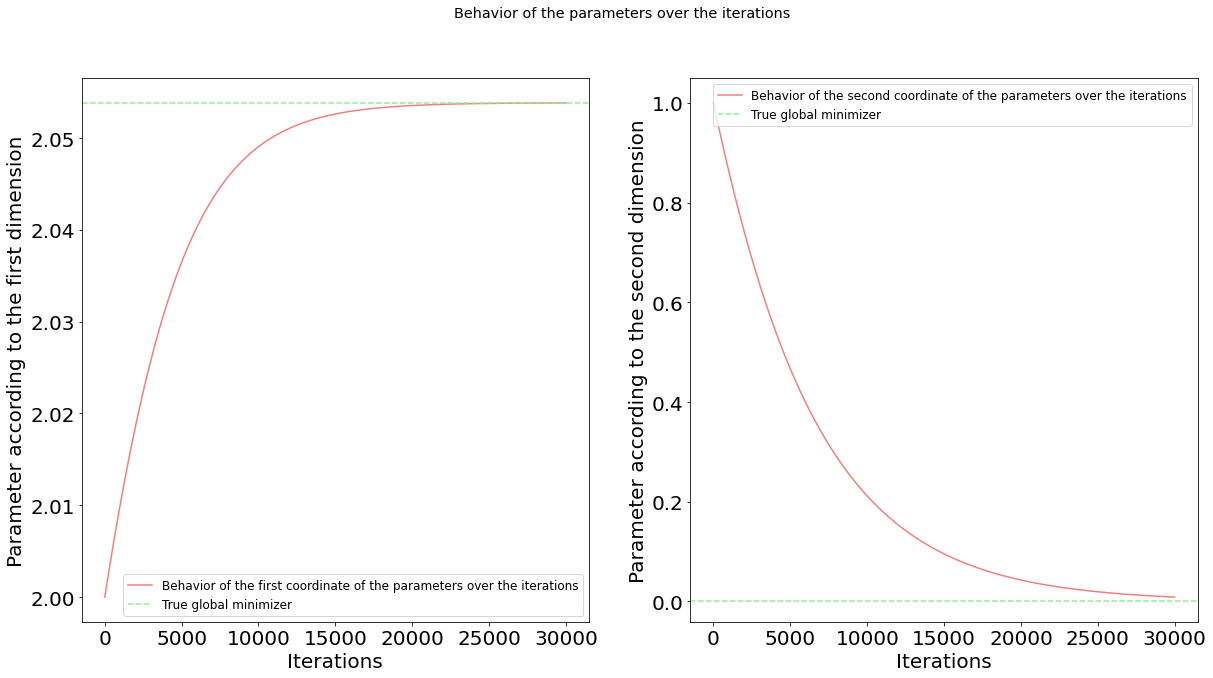

In [102]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
plt.rcParams['font.size']=12
fig.suptitle('Behavior of the parameters over the iterations')
ax[0].plot(range(len(weights[:, 0])), weights[:, 0], label='Behavior of the first coordinate of the parameters over the iterations', color='lightcoral')
ax[0].axhline(lambda_1objective, color='lightgreen', label='True global minimizer', linestyle='--')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Parameter according to the first dimension')
ax[0].legend()
ax[1].plot(range(len(weights[:, 1])), weights[:, 1], label='Behavior of the second coordinate of the parameters over the iterations', color='lightcoral')
ax[1].axhline(lambda_2objective, color='lightgreen', label='True global minimizer', linestyle='--')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Parameter according to the second dimension')
ax[1].legend()
plt.show(fig)

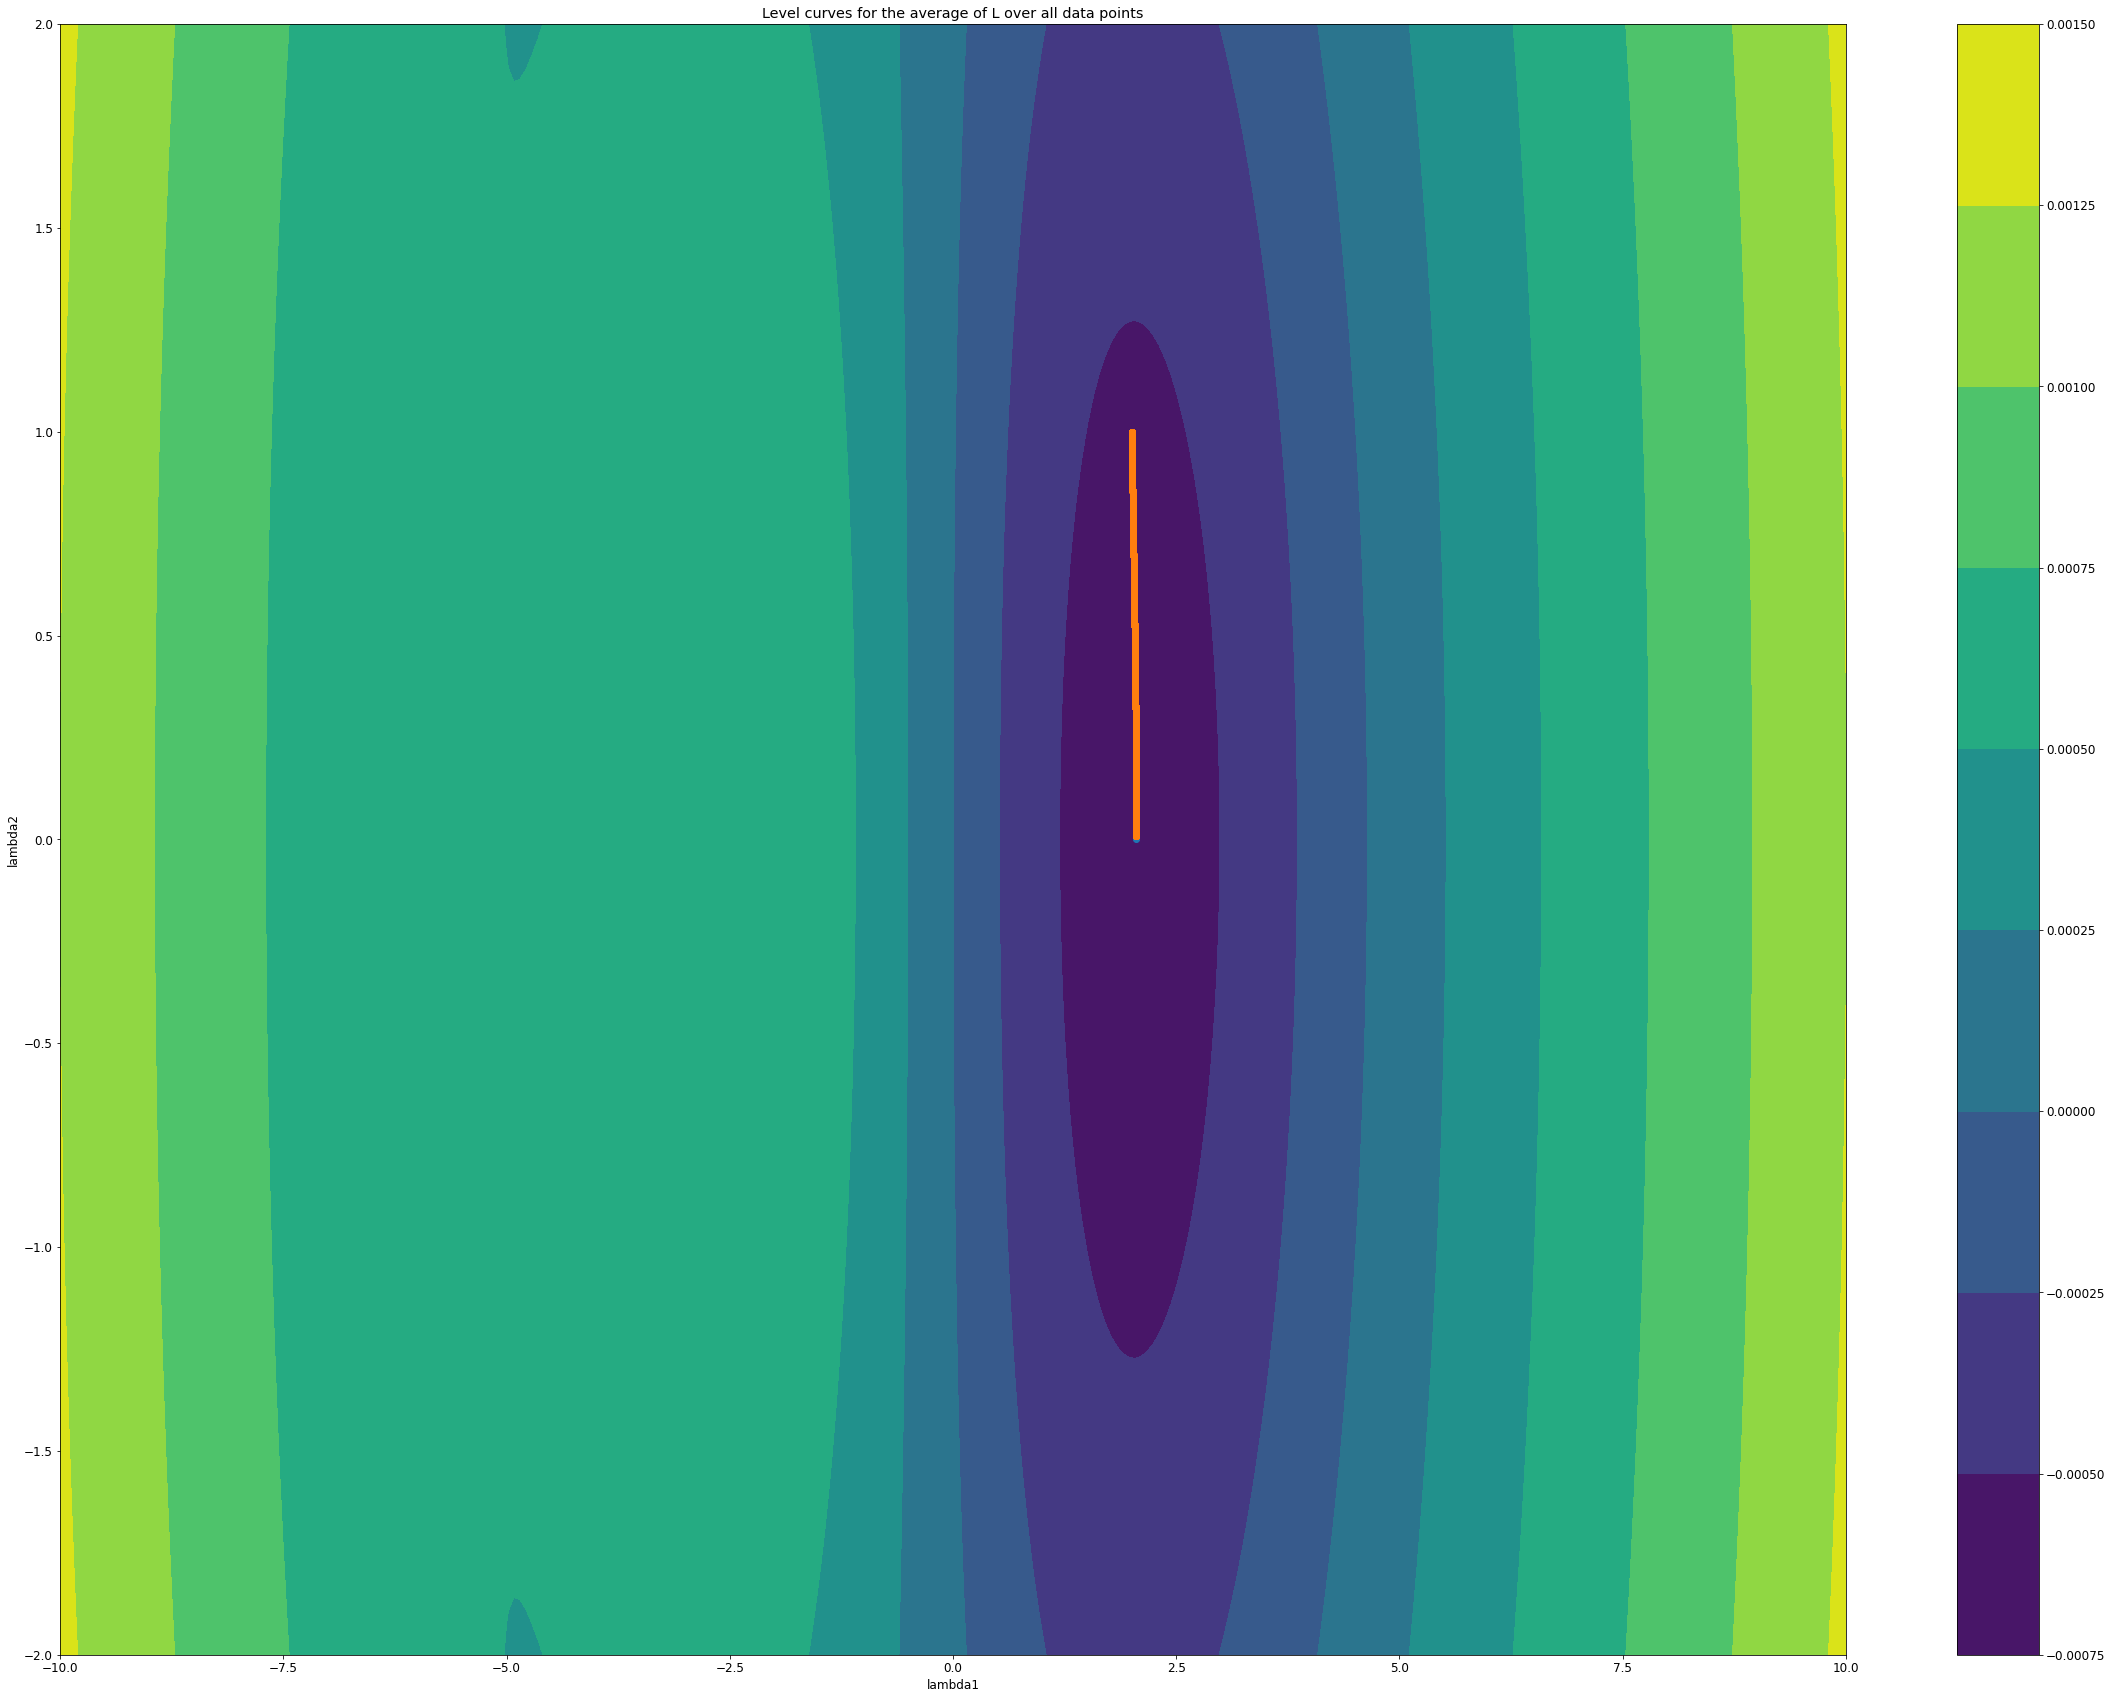

In [104]:
x_ax=np.linspace(-10,10,300)
y_ax=np.linspace(-2,2,300)
X_p, Y_p, Z_p=np.zeros((300,300)), np.zeros((300,300)), np.zeros((300,300))
for i in range(300):
    for j in range(300):
        Z_p[i][j]=L(x_ax[i],y_ax[j])
        X_p[i][j]=x_ax[i]
        Y_p[i][j]=y_ax[j]
fig,ax=plt.subplots(1,1)
fig.set_figheight(30)
fig.set_figwidth(40)
cp = ax.contourf(X_p,Y_p,Z_p)
fig.colorbar(cp) 
ax.set_title('Level curves for the average of L over all data points')
ax.set_xlabel('lambda1')
ax.set_ylabel('lambda2')
ax.scatter(2.05384,0)
ax.scatter(weights[:, 0], weights[:, 1])
plt.show()

Therefore, we can see that out parameters converge to the true values of the optimal parameters.
Now, in order to see if our stopping condition is effective, we can visualize the gradients since they are responsible for the update. A low gradient at the end of our algorithm means that they have 'vanished' and our update is no longer effective.

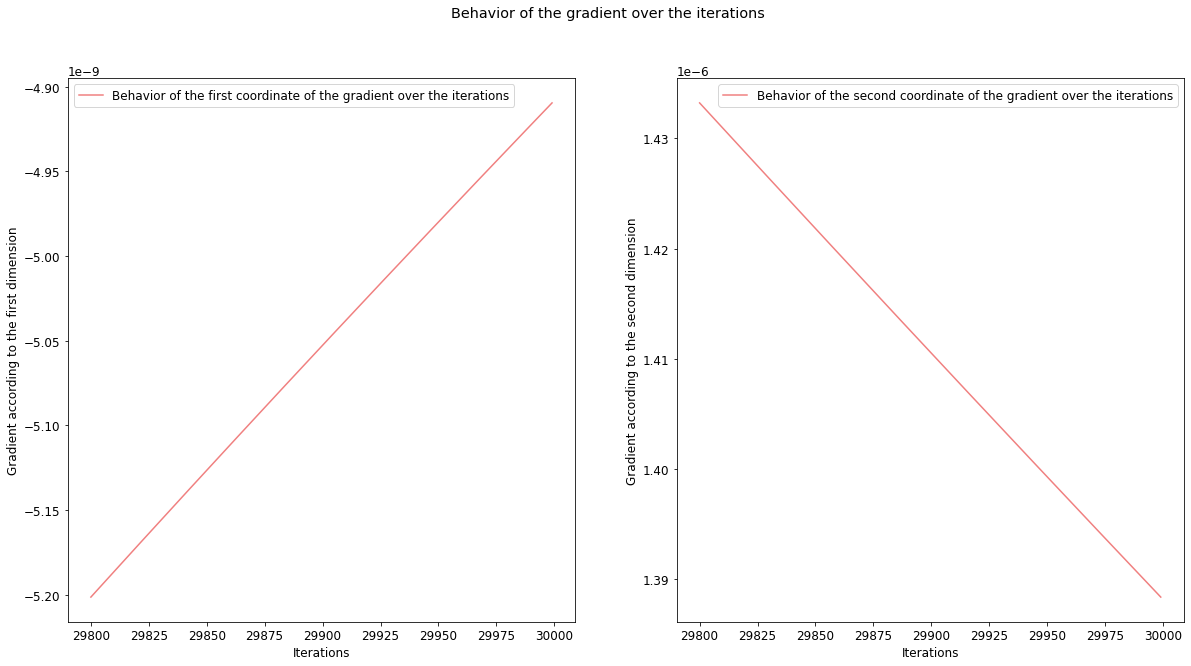

In [105]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
fig.suptitle('Behavior of the gradient over the iterations')
ax[0].plot(range(max_iter)[-200:], values_gradient[:, 0][-200:], label='Behavior of the first coordinate of the gradient over the iterations', color='lightcoral')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Gradient according to the first dimension')
ax[0].legend()
ax[1].plot(range(max_iter)[-200:], values_gradient[:, 1][-200:], label='Behavior of the second coordinate of the gradient over the iterations', color='lightcoral')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Gradient according to the second dimension')
ax[1].legend()
plt.show(fig)

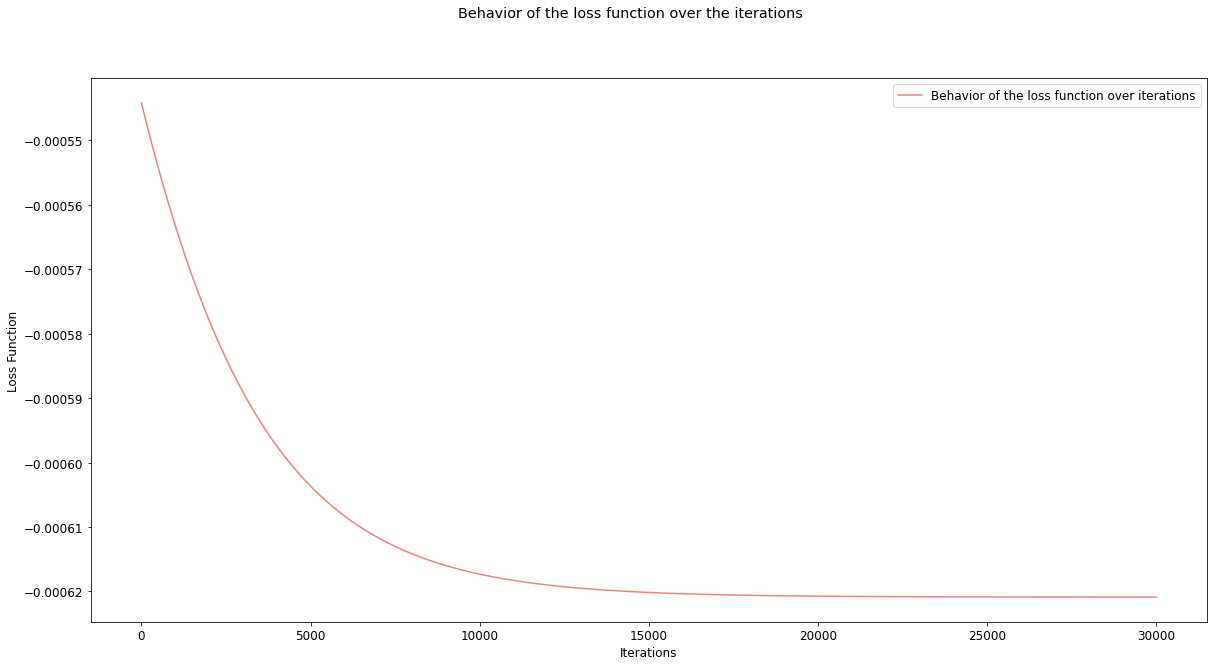

In [106]:
fig, ax = plt.subplots(1, figsize = (20, 10))
fig.suptitle('Behavior of the loss function over the iterations')
ax.plot(range(max_iter), values_function, label='Behavior of the loss function over iterations', color='lightcoral')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss Function')
ax.legend()
plt.show()

Our function value is pretty low along the iterations. It stabilizes next to 0 when performing 30000 iterations (~ 12 seconds)

**Global Diagnostics**: Converged

#### 3. Stochastic Gradient Descent

In [14]:
import random
import itertools

In [15]:
def stochastic_gradient_descent(partial_derivatives, mini_batch_size, data, function, learning_rate, initial_parameter, total_epoch): #try to make it generic
    """Performs the SGD algorithm.
    INPUTS
    ==============================
    partial_derivaties: a function computing the gradient for one observation (x, y)
    mini_batch_size: integer, the size of the batch in order to accelerate GD. 
    data : an array-like structure containing all of the points
    function : your loss function, function
    learning_rate : parameter of learning, float
    total_epoch: in order to stop the process in case of non-convergence (one epoch is one scan of the data)
    RETURNS
    ==============================
    function_values : an array containing the value of the function evaluated on the different parameters along iterations
    gradient_values: an array containing gradient values 
    weight_values: ''''
    """
    initial_weight = initial_parameter
    function_values = []
    gradient_values = []
    weights = [initial_weight]
    dataset = data[['x', 'y']].sample(frac=1).values
    for _ in itertools.repeat(None, total_epochs): #add stopping criteria
        mini_batchs = np.array_split(dataset, int(len(dataset)/mini_batch_size)) 
        for mini_batch in mini_batchs:
            if not stopping_condition_gradient(weights, function_values, gradient_values, 0, 1000):
                mini_batch_grad = np.mean(partial_derivatives(mini_batch[:, 0], mini_batch[:, 1], *weights[-1]), axis=0)
                new_weight = weights[-1] - learning_rate*mini_batch_grad
                gradient_values.append(mini_batch_grad)
                weights.append(new_weight)
                function_values.append(function(*weights[-1]))
    return function_values, np.asarray(values_gradient).reshape(-1, 2), np.asarray(weights).reshape(-1, 2)
        

In [16]:
mini_batch_size = 1
lr = 1
initial_parameter = np.array([2, 1])
total_epochs = 20
values_function_SGD, values_gradient_SGD, weights_SGD = stochastic_gradient_descent(aux, mini_batch_size, data, L, lr,  initial_parameter, total_epochs)

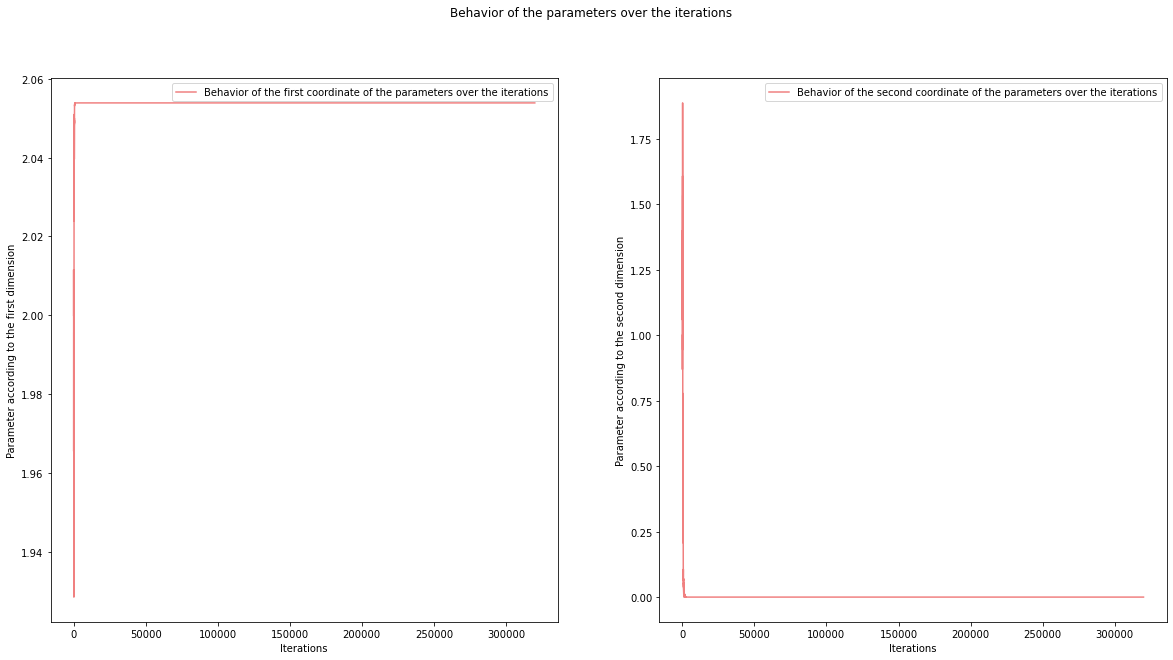

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
fig.suptitle('Behavior of the parameters over the iterations')
ax[0].plot(range(len(weights_SGD[:, 0])), weights_SGD[:, 0], label='Behavior of the first coordinate of the parameters over the iterations', color='lightcoral')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Parameter according to the first dimension')
ax[0].legend()
ax[1].plot(range(len(weights_SGD[:, 1])), weights_SGD[:, 1], label='Behavior of the second coordinate of the parameters over the iterations', color='lightcoral')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Parameter according to the second dimension')
ax[1].legend()
plt.show(fig)

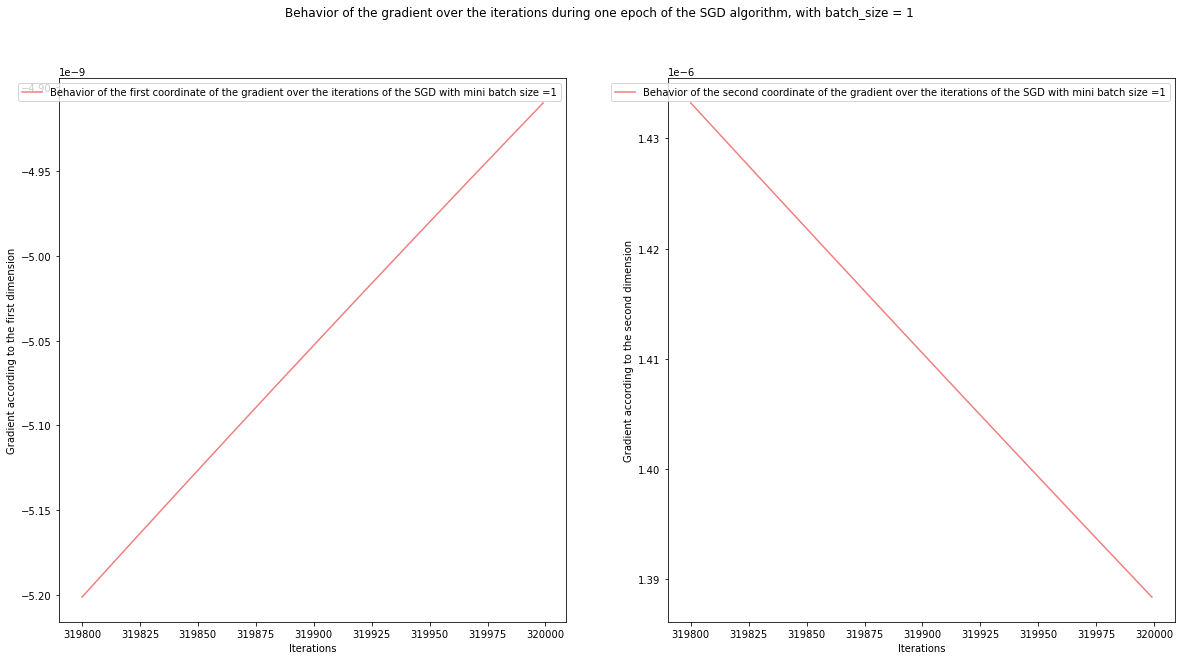

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
fig.suptitle('Behavior of the gradient over the iterations during one epoch of the SGD algorithm, with batch_size = 1')
ax[0].plot(range(len(values_function_SGD))[-200:], values_gradient_SGD[:, 0][-200:], label='Behavior of the first coordinate of the gradient over the iterations of the SGD with mini batch size =1', color='lightcoral')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Gradient according to the first dimension')
ax[0].legend()
ax[1].plot(range(len(values_function_SGD))[-200:], values_gradient_SGD[:, 1][-200:], label='Behavior of the second coordinate of the gradient over the iterations of the SGD with mini batch size =1', color='lightcoral')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Gradient according to the second dimension')
ax[1].legend()
plt.show(fig)

Let us check for convergence of our algorithm after $N=20$ epochs. 

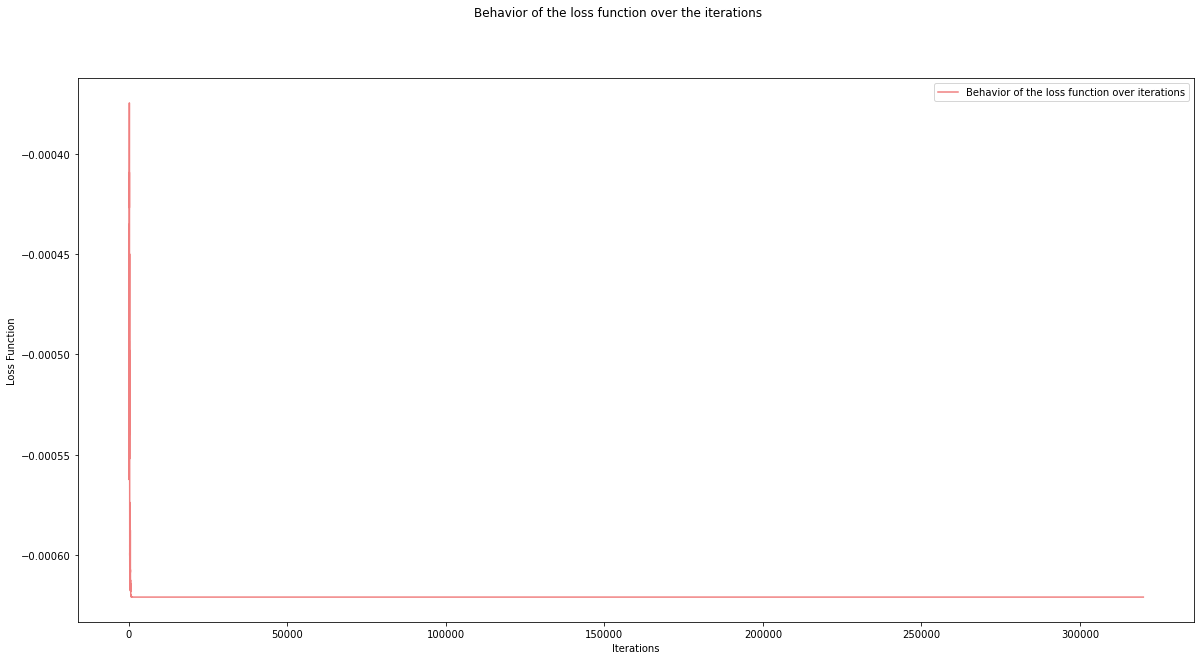

In [19]:
fig, ax = plt.subplots(1, figsize = (20, 10))
fig.suptitle('Behavior of the loss function over the iterations')
ax.plot(range(len(values_function_SGD)), values_function_SGD, label='Behavior of the loss function over iterations', color='lightcoral')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss Function')
ax.legend()
plt.show()

Therefore, we can see that our SGD algorithm has converged after $N = 20$ epochs (~60 seconds).

#### 4. Compare GD and SGD Fairly

Here, we defined the net loss as being the loss over the entire locations. Therefore, the net loss can be computed as the sum of the losses accross the entire locations. Minimizing this function is equivalent to minimizing this function divided by any constant. This is why minimizing the average loss (mean of losses) is equivalent to minimizing the net loss (sum of losses).

Now, averaging the net loss means that the optimization problem solved by Gradient Descent is:
$$
argmin_{lambda_1, lambda_2}\frac{1}{m}\sum_{i=1}^ml(x_i, y_i, \lambda_1, \lambda_2)
$$

Let us show that the stochastic gradient descent tries to solve the same problem. Since we add randomness in the Stochastic gradient descent step, we are going to show that the expectancy of the function minimized by SGD is equal to the one we optimize during GD.

We dram $I \sim \mathcal{U}(0,m)$ and we compute a GD step for $l(x_I, y_I, \lambda_1, \lambda_2) = \sum_{i=1}^ml(x_i, y_i, \lambda_1, \lambda_2)\mathbb{1}_{I=i}$.

Therefore, on average, the optimized loss function is $\mathbb{E}{(l(x_I, y_I, \lambda_1, \lambda_2))} = \sum_{i=1}^ml(x_i, y_i, \lambda_1, \lambda_2)\mathbb{P}(I=i) = \frac{1}{m}\sum_{i=1}^ml(x_i, y_i, \lambda_1, \lambda_2)$

#### 5. Compare the efficiency of GD and SGD 

Now, we will compute the same amount of iterations for both GD and SGD.

##### Time efficiency

In [21]:
import time

In [50]:
lr = 1
max_iter = 64000
initial_parameter = np.array([2, 1]).T
init = time.time()
values_function, values_gradient, weights = gradient_descent(grad, L, lr, stopping_condition_gradient, initial_parameter, max_iter)
mean_iter = (time.time()-init)/max_iter
print('An iteration of GD takes on average ', mean_iter, ' seconds')

An iteration of GD takes on average  0.0004032112918794155  seconds


In [51]:
mini_batch_size = 1
lr = 1
initial_parameter = np.array([2, 1])
total_epochs = 4
init = time.time()
values_function_SGD, values_gradient_SGD, weights_SGD = stochastic_gradient_descent(aux, mini_batch_size, data, L, lr,  initial_parameter, total_epochs)
mean_iter = (time.time()-init)/(total_epochs*len(data))
print('An iteration of SGD takes on average ', mean_iter, ' seconds')

An iteration of SGD takes on average  0.00018923461064696313  seconds


The faster method is SGD. This should be expected because this is the whole point of using the stochastic gradient descent. For large datasets, optimizing via Gradient Descent might become intractable since for every update, we need to compute the loss of the **entire training log-likelihood**. A shortcut to this issue is to use the Stochastic Gradient descent, which will use smaller sets of data in order to compute the gradient and update the parameters (a batch). Here, the batch size is 1, meaning that we update our parameters after every computation of 1 gradient. 

##### Efficiency in terms of iteration


In [52]:
distance_to_opt_GD = np.linalg.norm(weights-optimal_weight, axis=1)

In [53]:
distance_to_opt_SGD = np.linalg.norm(weights_SGD-optimal_weight, axis=1)

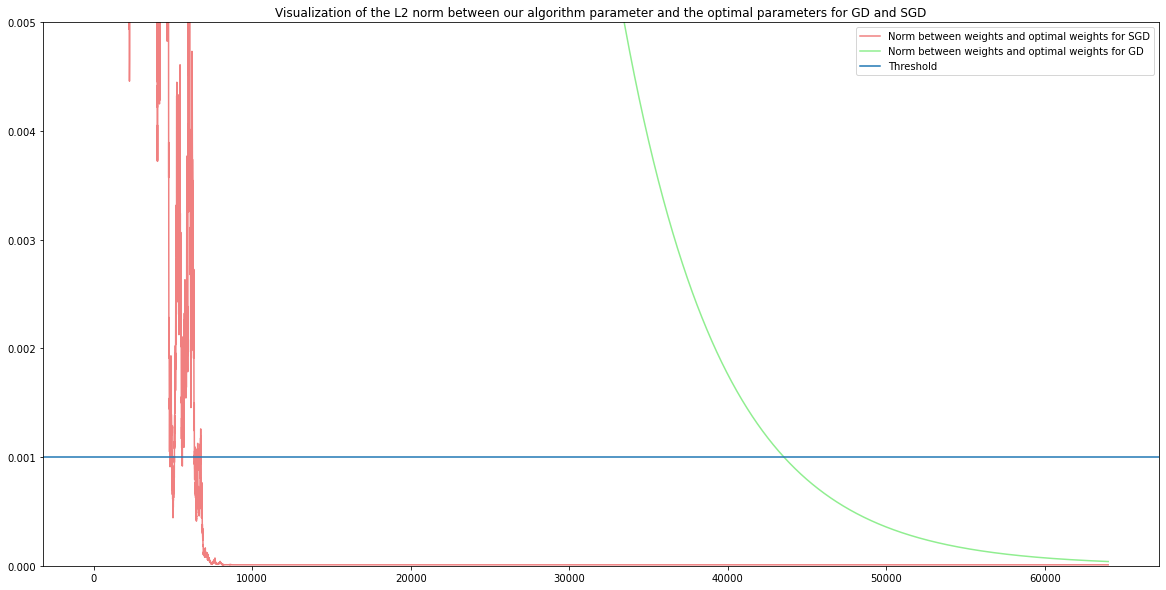

In [64]:
fig, ax = plt.subplots(1, figsize =(20, 10))
ax.plot(distance_to_opt_SGD, color='lightcoral', label='Norm between weights and optimal weights for SGD')
ax.plot(distance_to_opt_GD, color='lightgreen', label='Norm between weights and optimal weights for GD')
ax.set_ylim(0, 0.005)
plt.axhline(1e-3, label='Threshold')
ax.legend()
ax.set_title('Visualization of the L2 norm between our algorithm parameter and the optimal parameters for GD and SGD')
plt.show(fig)

Therefore, the SGD converges to the optimal point in far fewer iterations. I don't think that this result should **always** be expected when comparing GD and SGD. For instance, if I run my algorithm 100000 more epochs for SGD, I can not guarantee that I will still be stuck at this optima, whereas I can do so for Gradient Descent. I believe also that initialization has a great impact on how our algorithms behave.

#### 6. Comparing Sensitivity of GD and SGD to Learning Rate

##### For Gradient Descent 

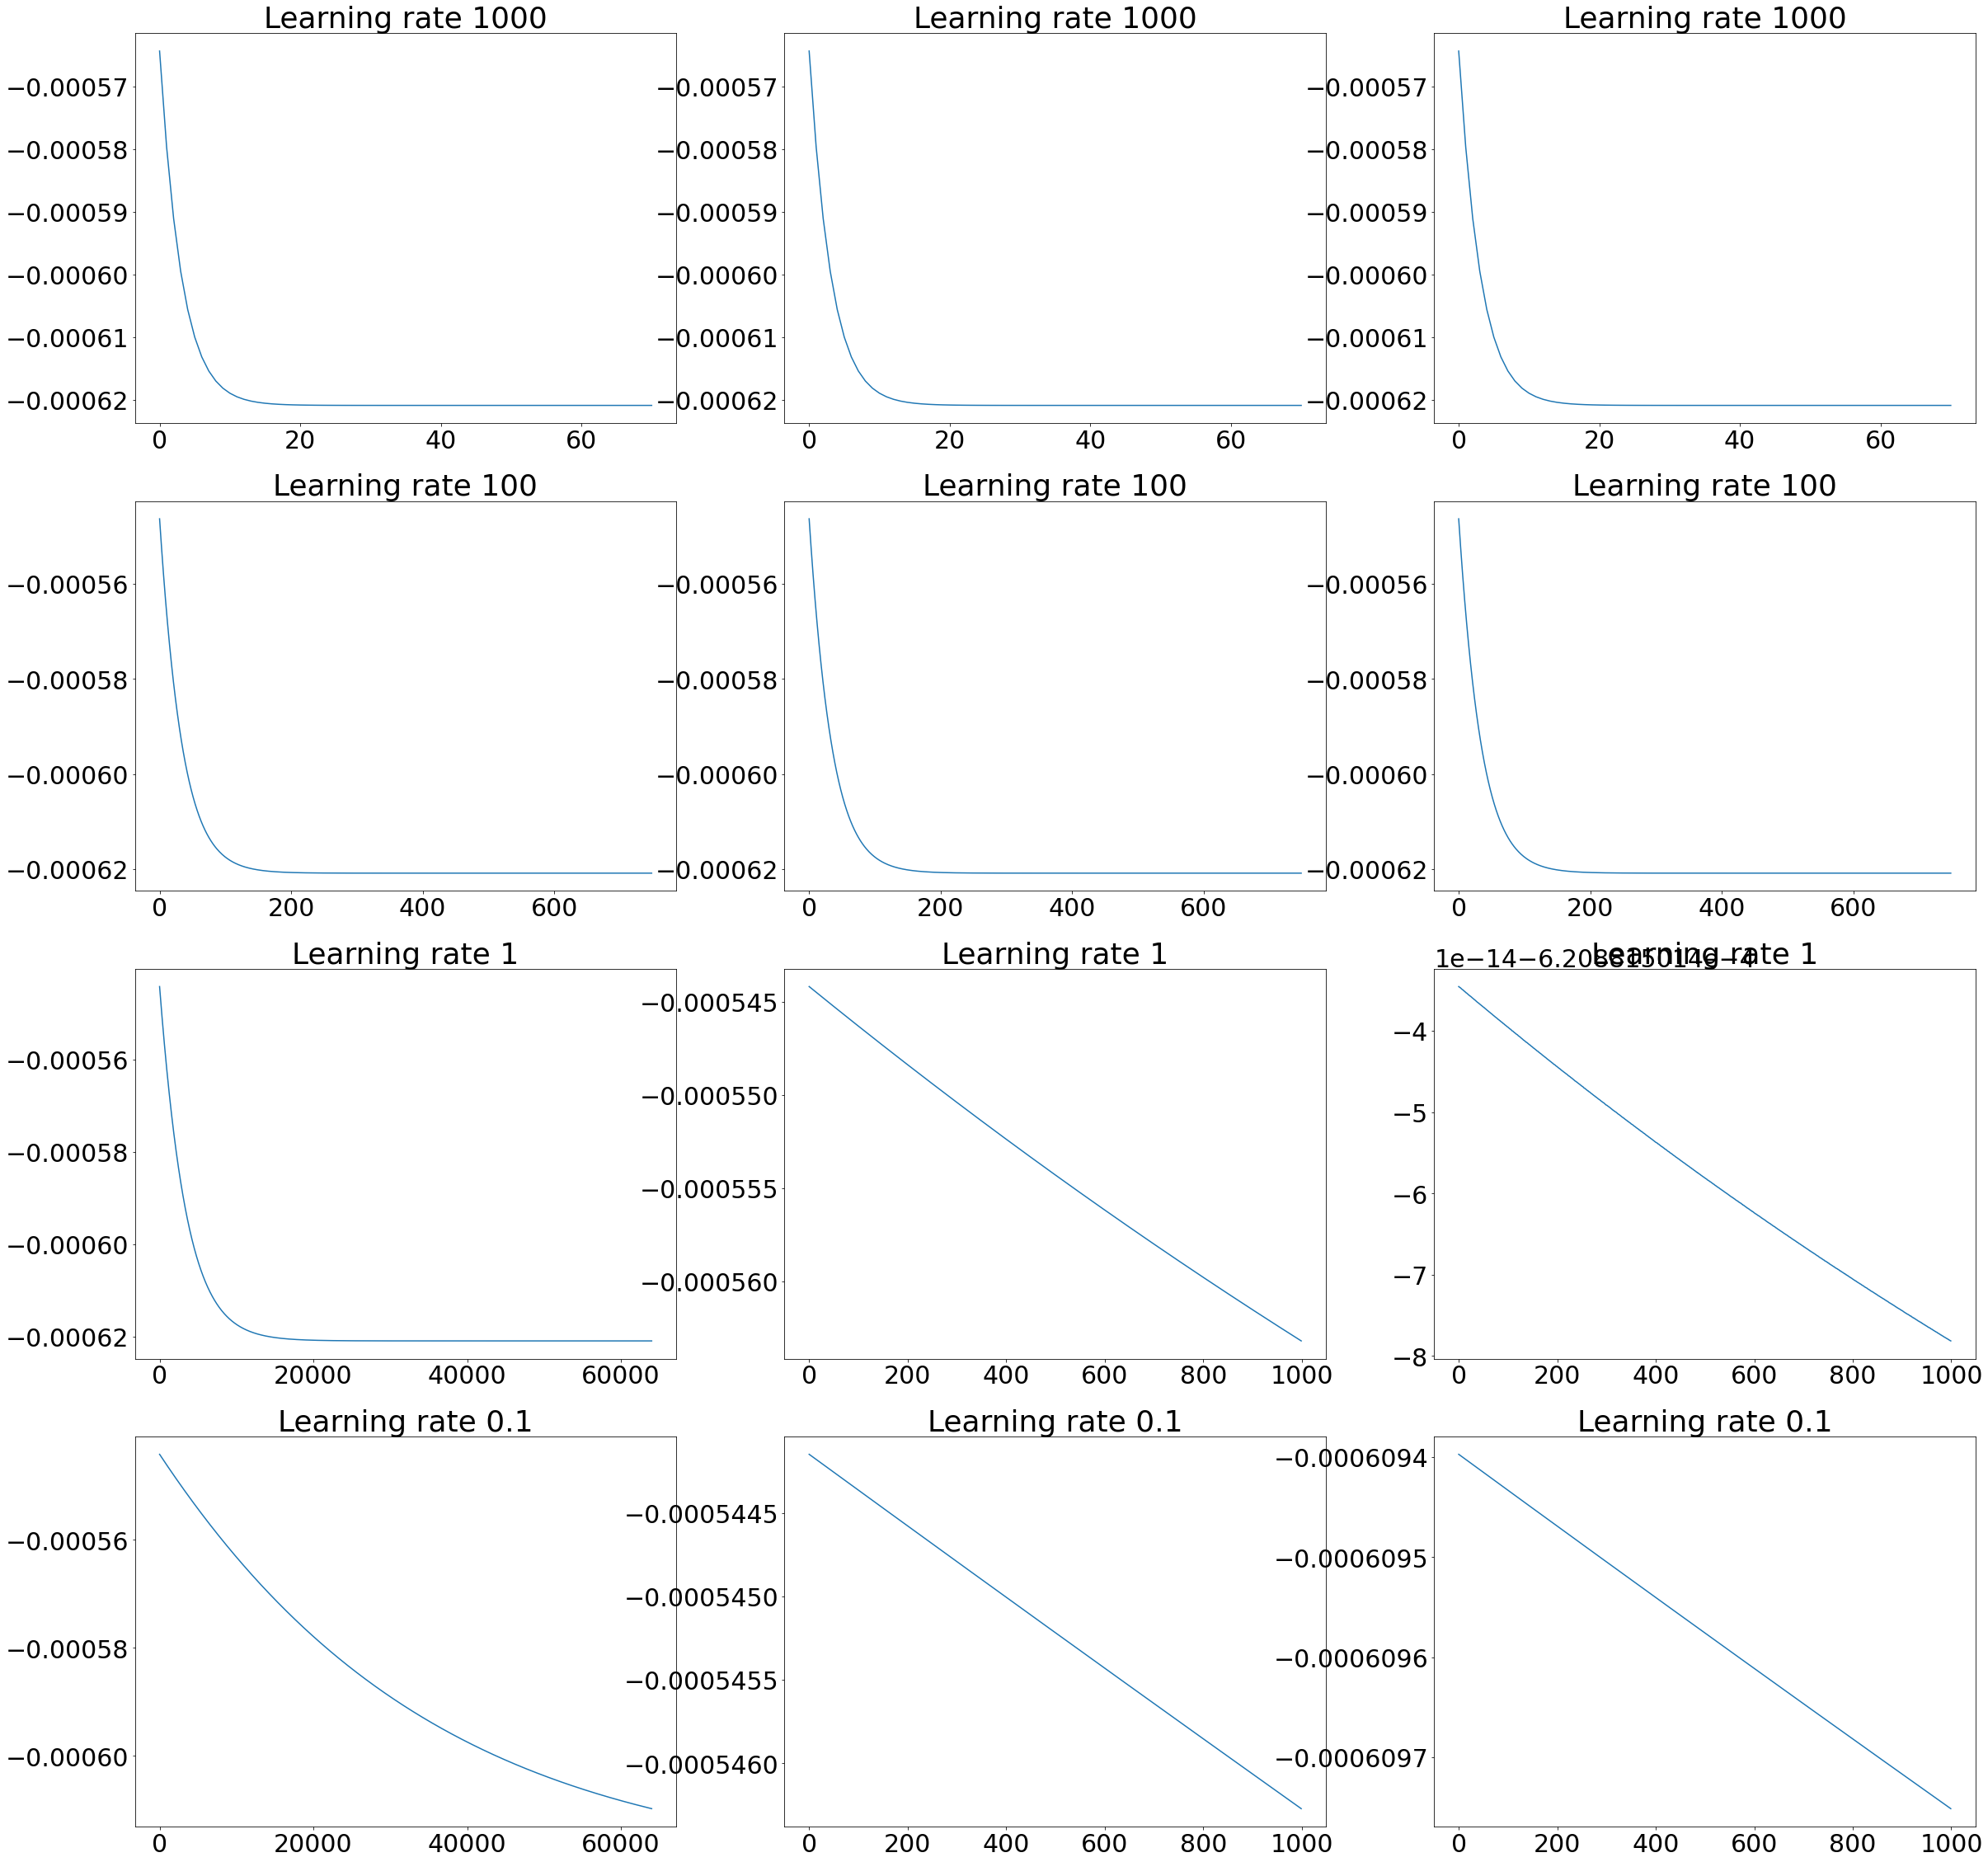

In [87]:
lrs = [1000, 100, 1, 0.1]
max_iter = 64000
initial_parameter = np.array([2, 1]).T
fig, axes = plt.subplots(4, 3, figsize = (40, 15))
fig.set_figheight(40)
#plt.suptitle('Visualization of the effect of the learning rate on GD convergence (loss function over the iterations)')
for i, lr in enumerate(lrs):
    values_function, values_gradient, weights = gradient_descent(grad, L, lr, stopping_condition_gradient, initial_parameter, max_iter)
    axes[i, 0].set_title('Learning rate ' + str(lr))
    axes[i, 1].set_title('Learning rate ' + str(lr))
    axes[i, 2].set_title('Learning rate ' + str(lr))
    axes[i, 0].plot(values_function, label='Behavior over the total number of iterations')
    axes[i, 1].plot(values_function[:1000], label='Behavior over the first couples of iterations')
    axes[i, 2].plot(values_function[-1000:], label='Behavior over the first couples of iterations')

One particularity of the GD is that, since we initialize our descent next to the optimal points, using a high learning rate allows us to converge faster towards these optimal points.

##### For Stochastic Gradient Descent

In [76]:
import warnings
warnings.filterwarnings('ignore')

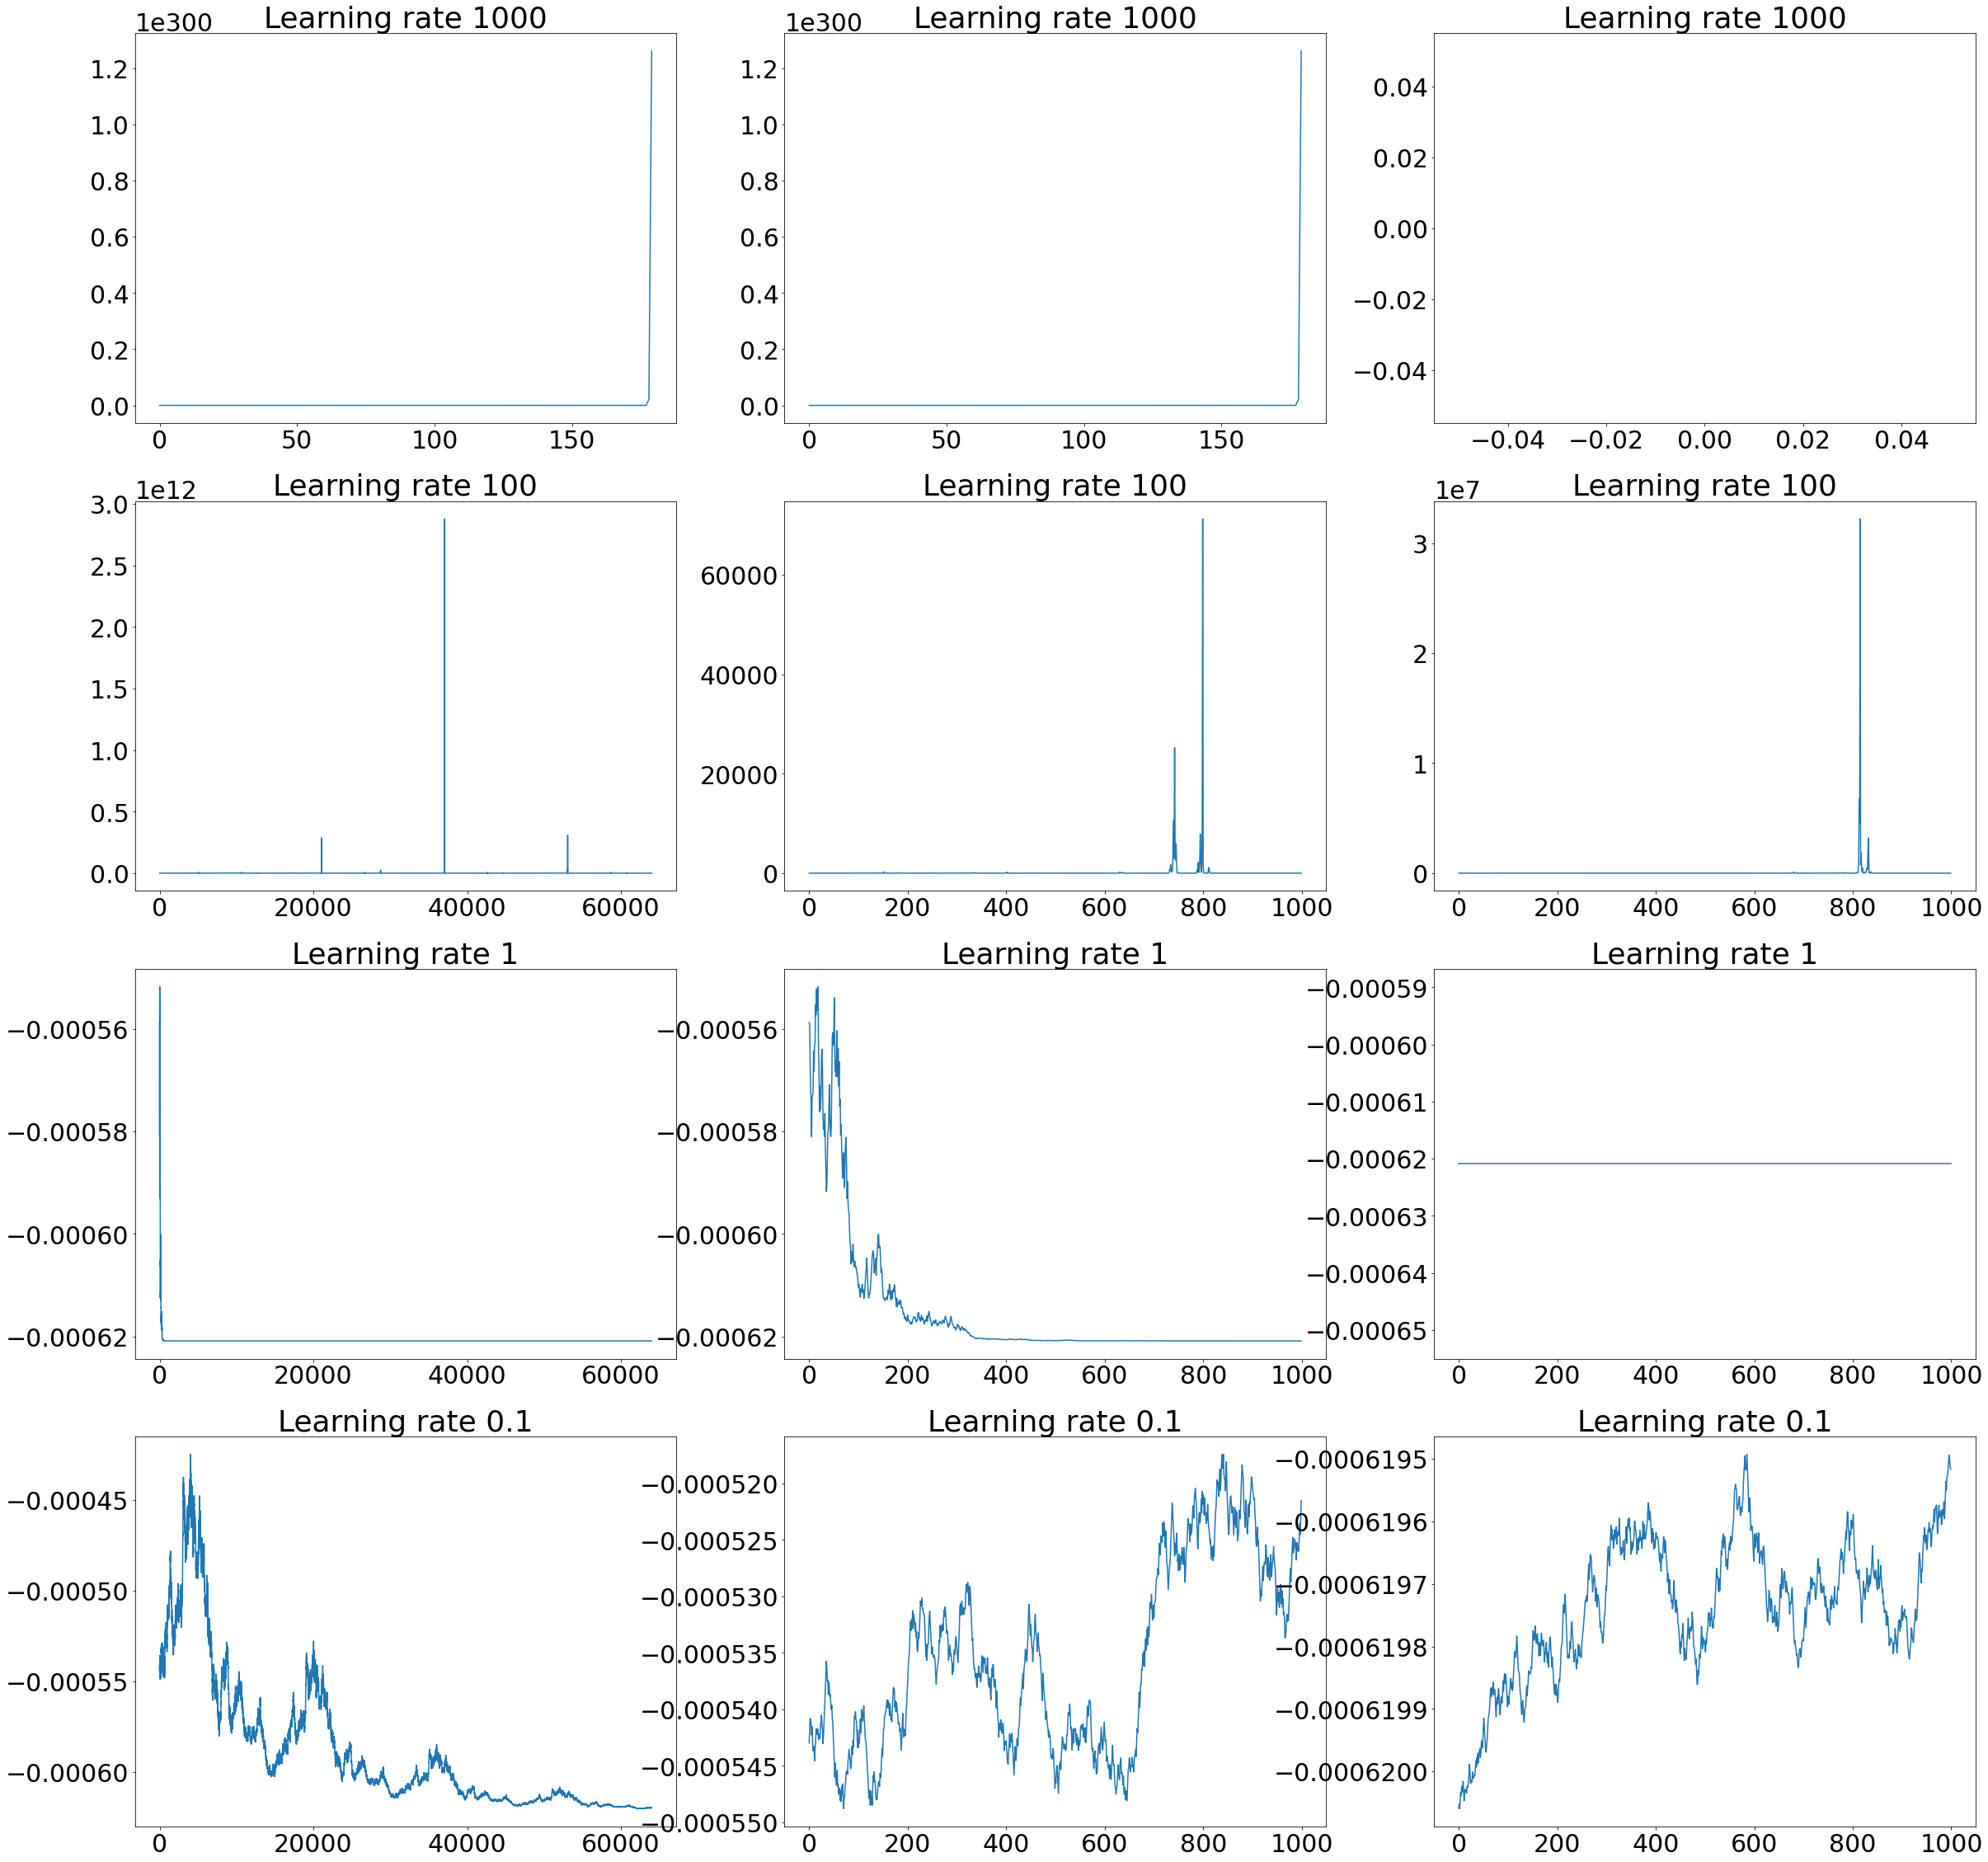

In [88]:
lrs = [1000, 100, 1, 0.1]
max_iter = 64000
initial_parameter = np.array([2, 1]).T
fig, axes = plt.subplots(4, 3, figsize = (40, 15))
fig.set_figheight(40)
#plt.suptitle('Visualization of the effect of the learning rate on SGD convergence (loss function over the iterations)')
for i, lr in enumerate(lrs):
    values_function_SGD, values_gradient_SGD, weights_SGD = stochastic_gradient_descent(aux, mini_batch_size, data, L, lr,  initial_parameter, total_epochs)
    axes[i, 0].set_title('Learning rate ' + str(lr))
    axes[i, 1].set_title('Learning rate ' + str(lr))
    axes[i, 2].set_title('Learning rate ' + str(lr))
    axes[i, 0].plot(values_function_SGD, label='Behavior over the total number of iterations')
    axes[i, 1].plot(values_function_SGD[:1000], label='Behavior over the first couples of iterations')
    axes[i, 2].plot(values_function_SGD[-1000:], label='Behavior over the first couples of iterations')

For our specific case, when starting close from our optimal point, increasing the learning rate allows to converge faster when using gradient descent. However, for stochastic gradient descent, the results are far disparate according to the learning rate. For big learning rates, we lose convergence. For small learning rates, the convergence is slower. This is due to the fact that when multiplying the mini batch gradient wiht the learning rate, we end up multiplying the variance by the square of the learning rate, explaining why the learning rate has such importance for SGD.   

#### 7. Comparing Sensitivity of GD and SGD to Initialization

##### For GD

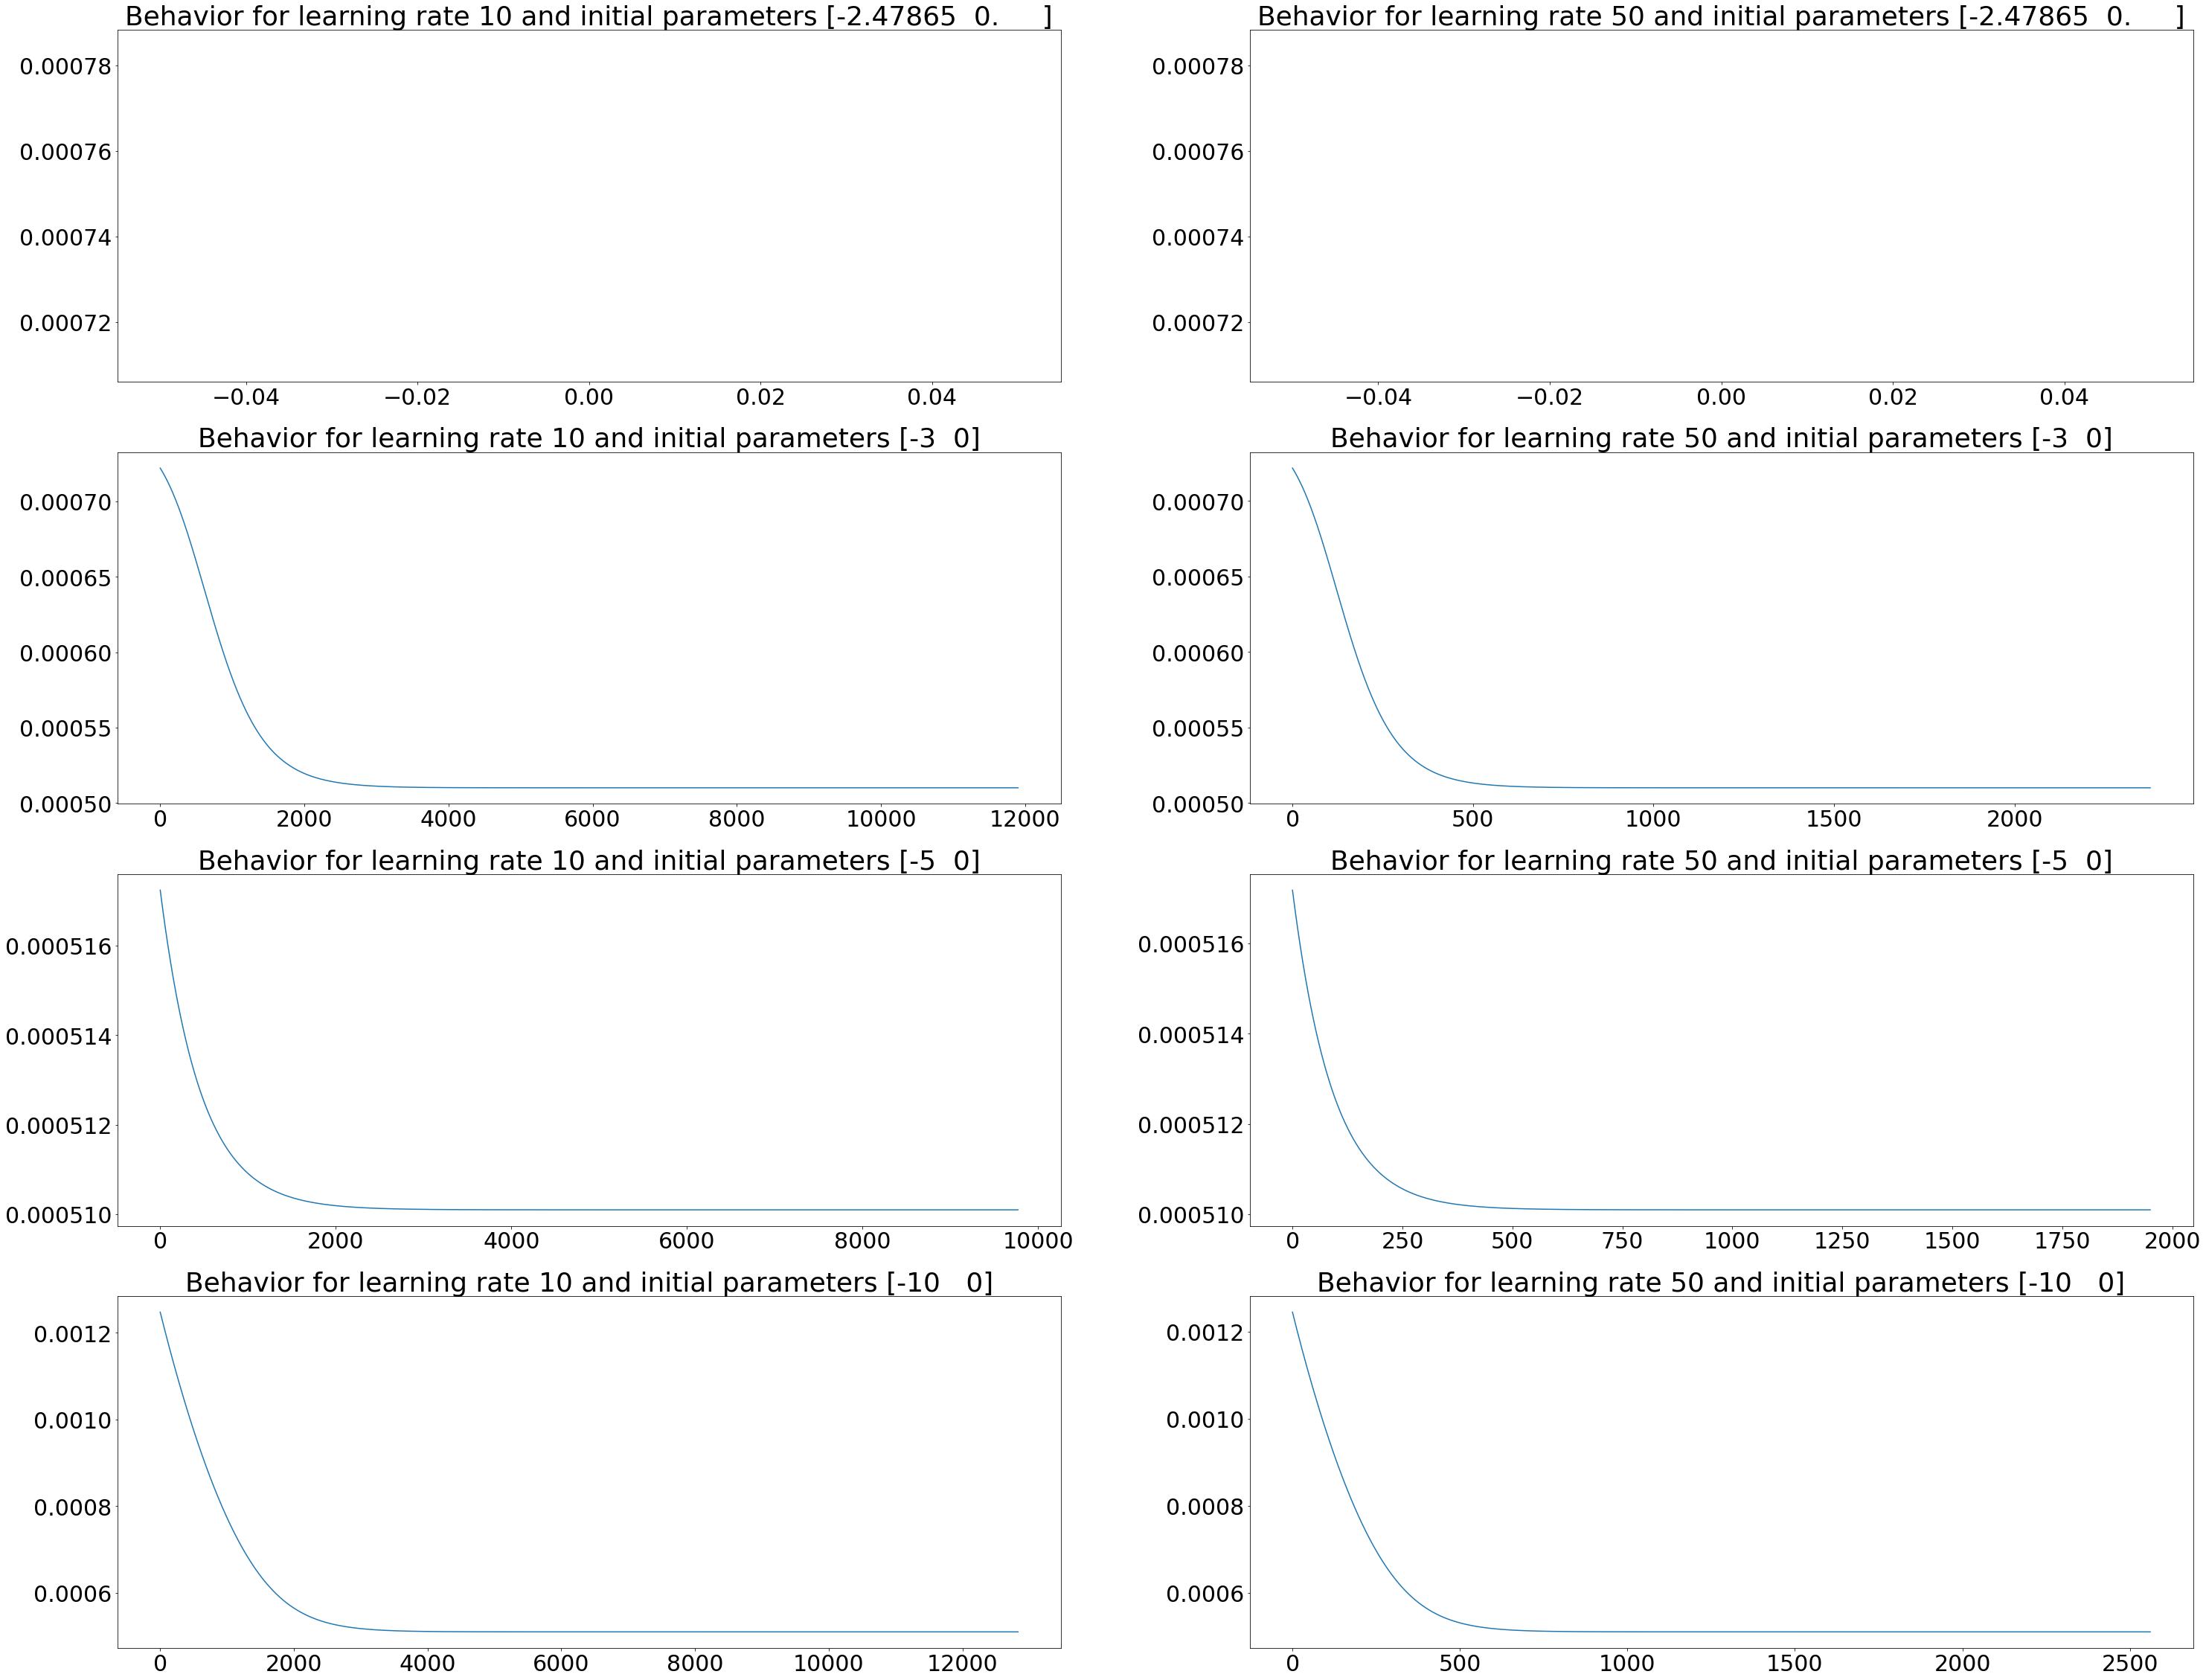

In [89]:
lr = 1
max_iter = 64000
initial_parameters = [np.array([-2.47865, 0]).T, np.array([-3, 0]).T, np.array([-5, 0]).T, np.array([-10, 0]).T]
lrs = [10, 50]
fig, axes = plt.subplots(4, 2, figsize = (50, 30))
fig.set_figheight(40)
plt.rcParams['font.size'] = 30
for i, initial_parameter in enumerate(initial_parameters):
    for j, lr in enumerate(lrs):
        values_function, values_gradient, weights = gradient_descent(grad, L, lr, stopping_condition_gradient, initial_parameter, max_iter)
        axes[i, j].plot(values_function)
        axes[i, j].set_title('Behavior for learning rate '+str(lr) +' and initial parameters '+ str(initial_parameter))

##### For SGD

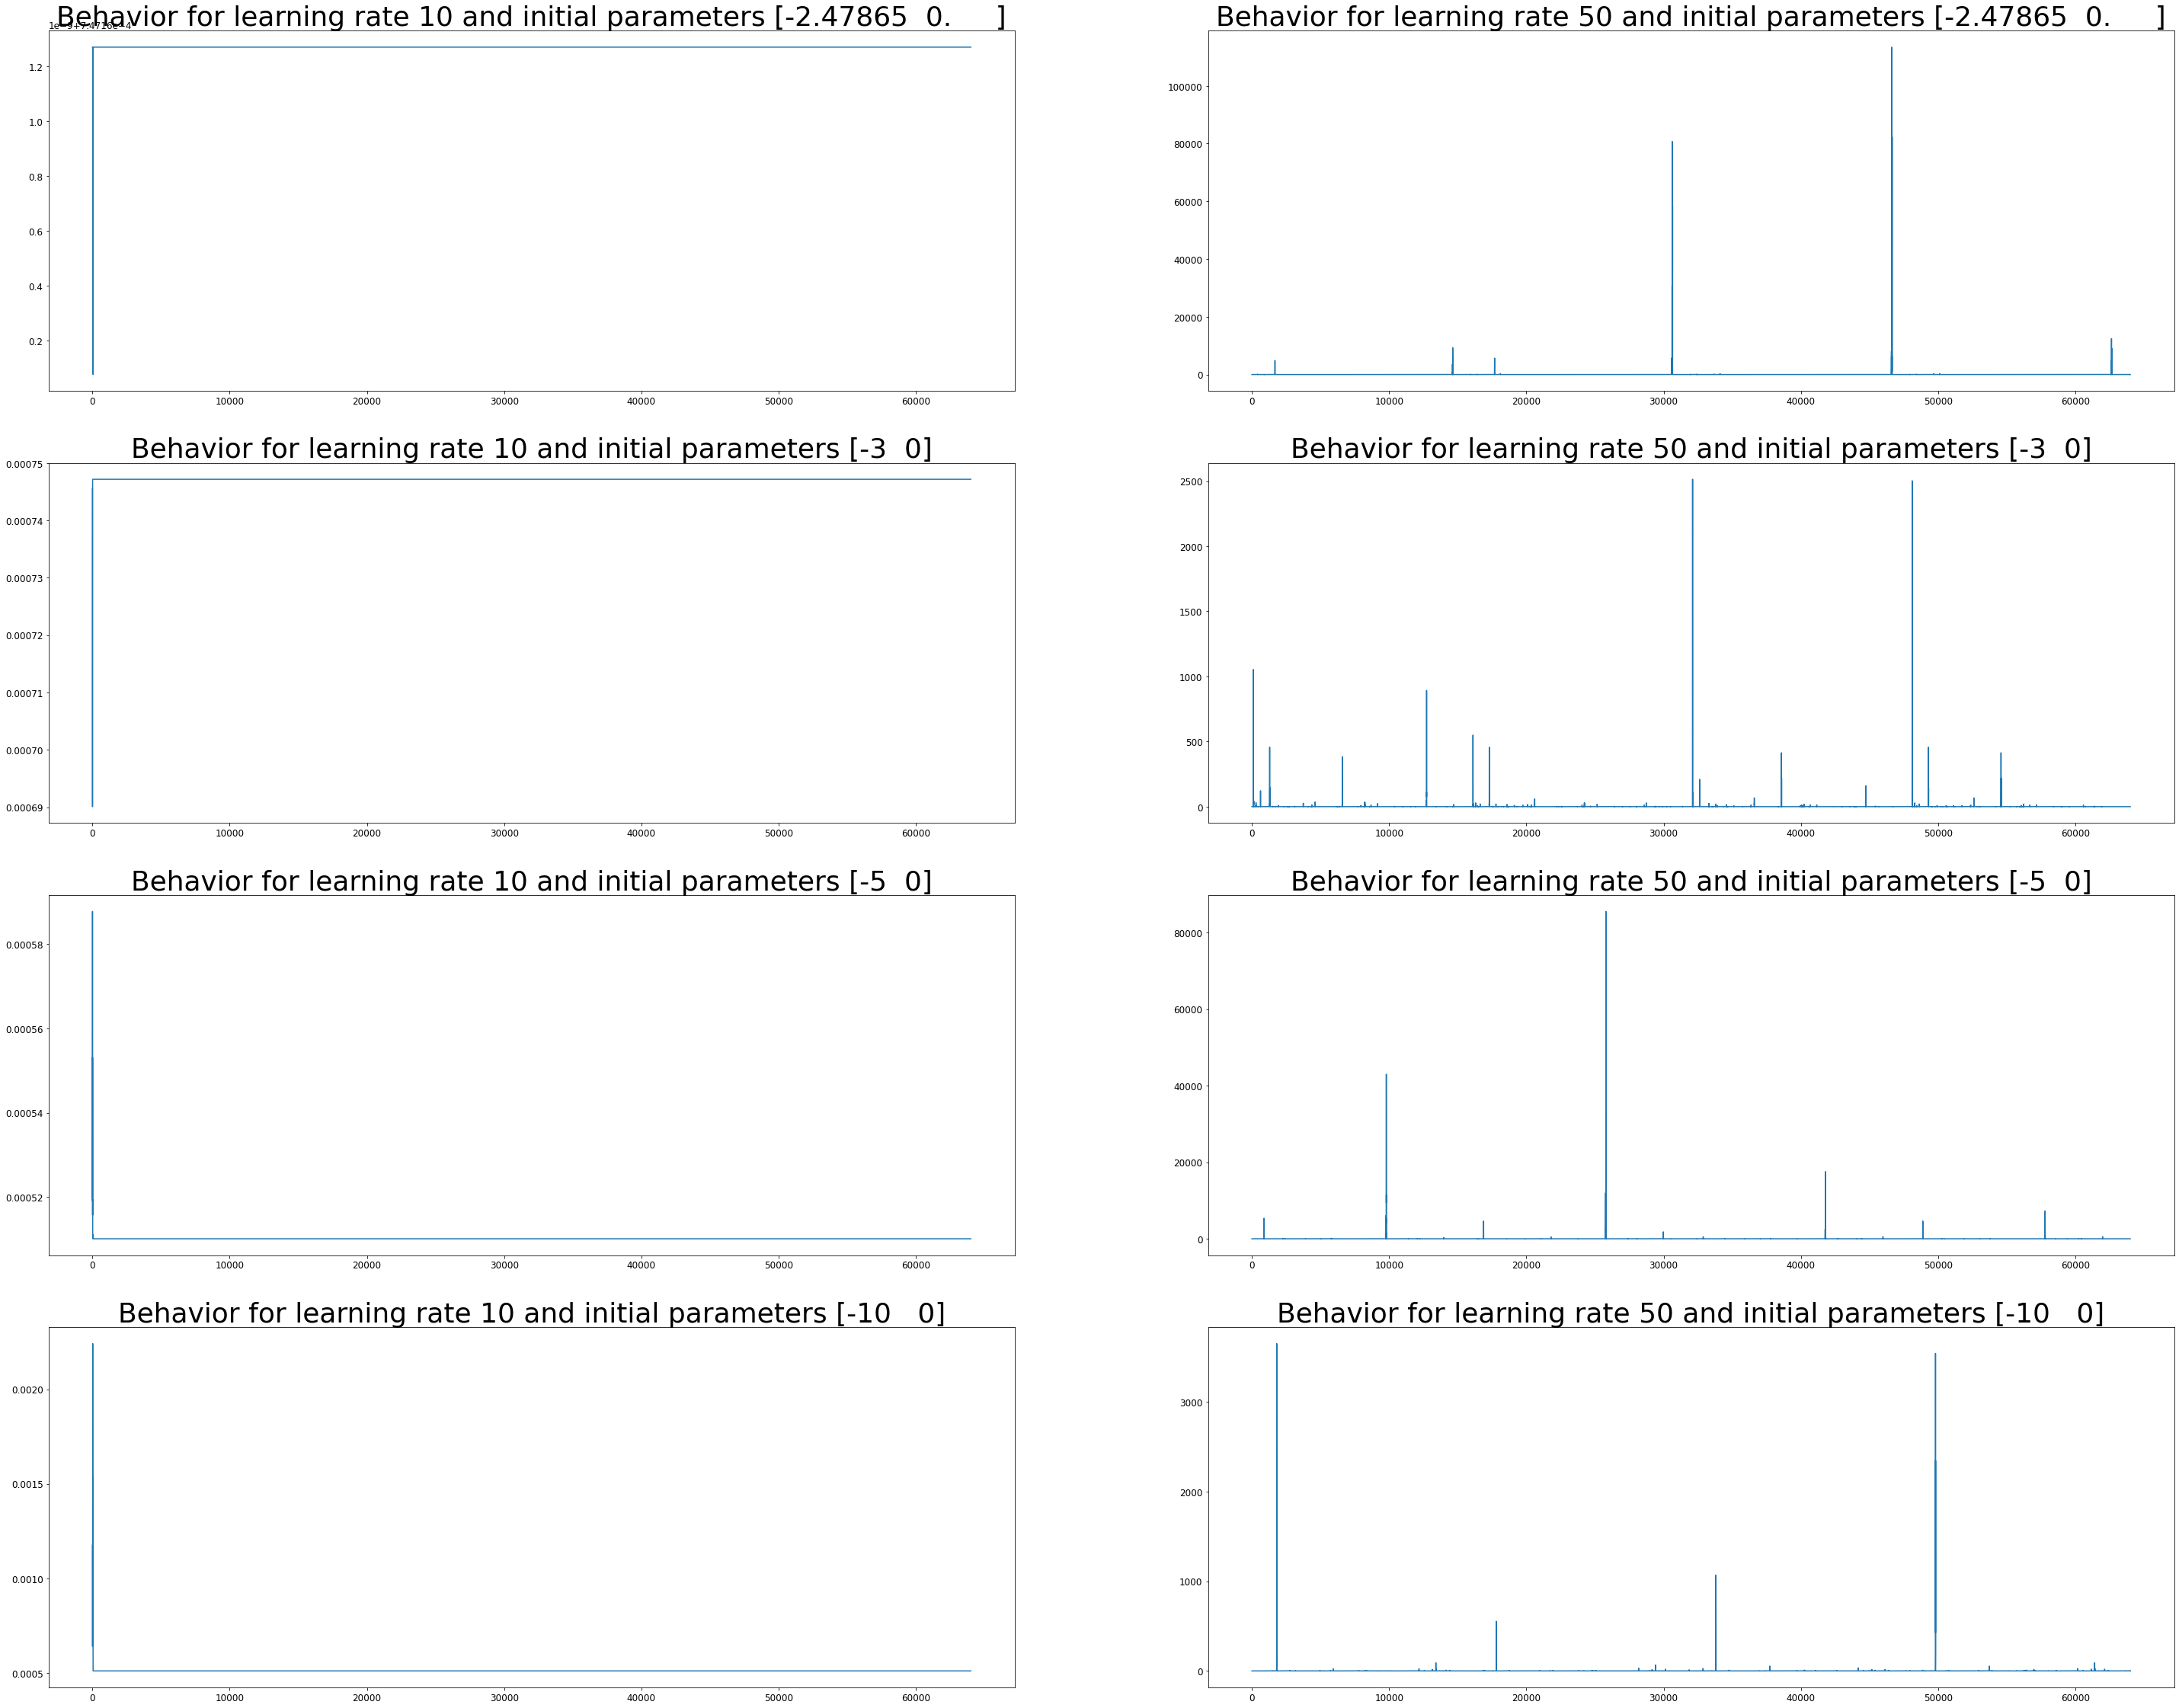

In [107]:
lr = 1
initial_parameters = [np.array([-2.47865, 0]).T, np.array([-3, 0]).T, np.array([-5, 0]).T, np.array([-10, 0]).T]
lrs = [10, 50]
fig, axes = plt.subplots(4, 2, figsize = (50, 30))
fig.set_figheight(40)
plt.rcParams['font.size'] = 30
for i, initial_parameter in enumerate(initial_parameters):
    for j, lr in enumerate(lrs):
        values_function_SGD, values_gradient_SGD, weights_SGD = stochastic_gradient_descent(aux, mini_batch_size, data, L, lr,  initial_parameter, total_epochs)
        axes[i, j].plot(values_function_SGD)
        axes[i, j].set_title('Behavior for learning rate '+str(lr) +' and initial parameters '+ str(initial_parameter))

In [114]:
print(np.max(weights_SGD[:, 1]))

0.0


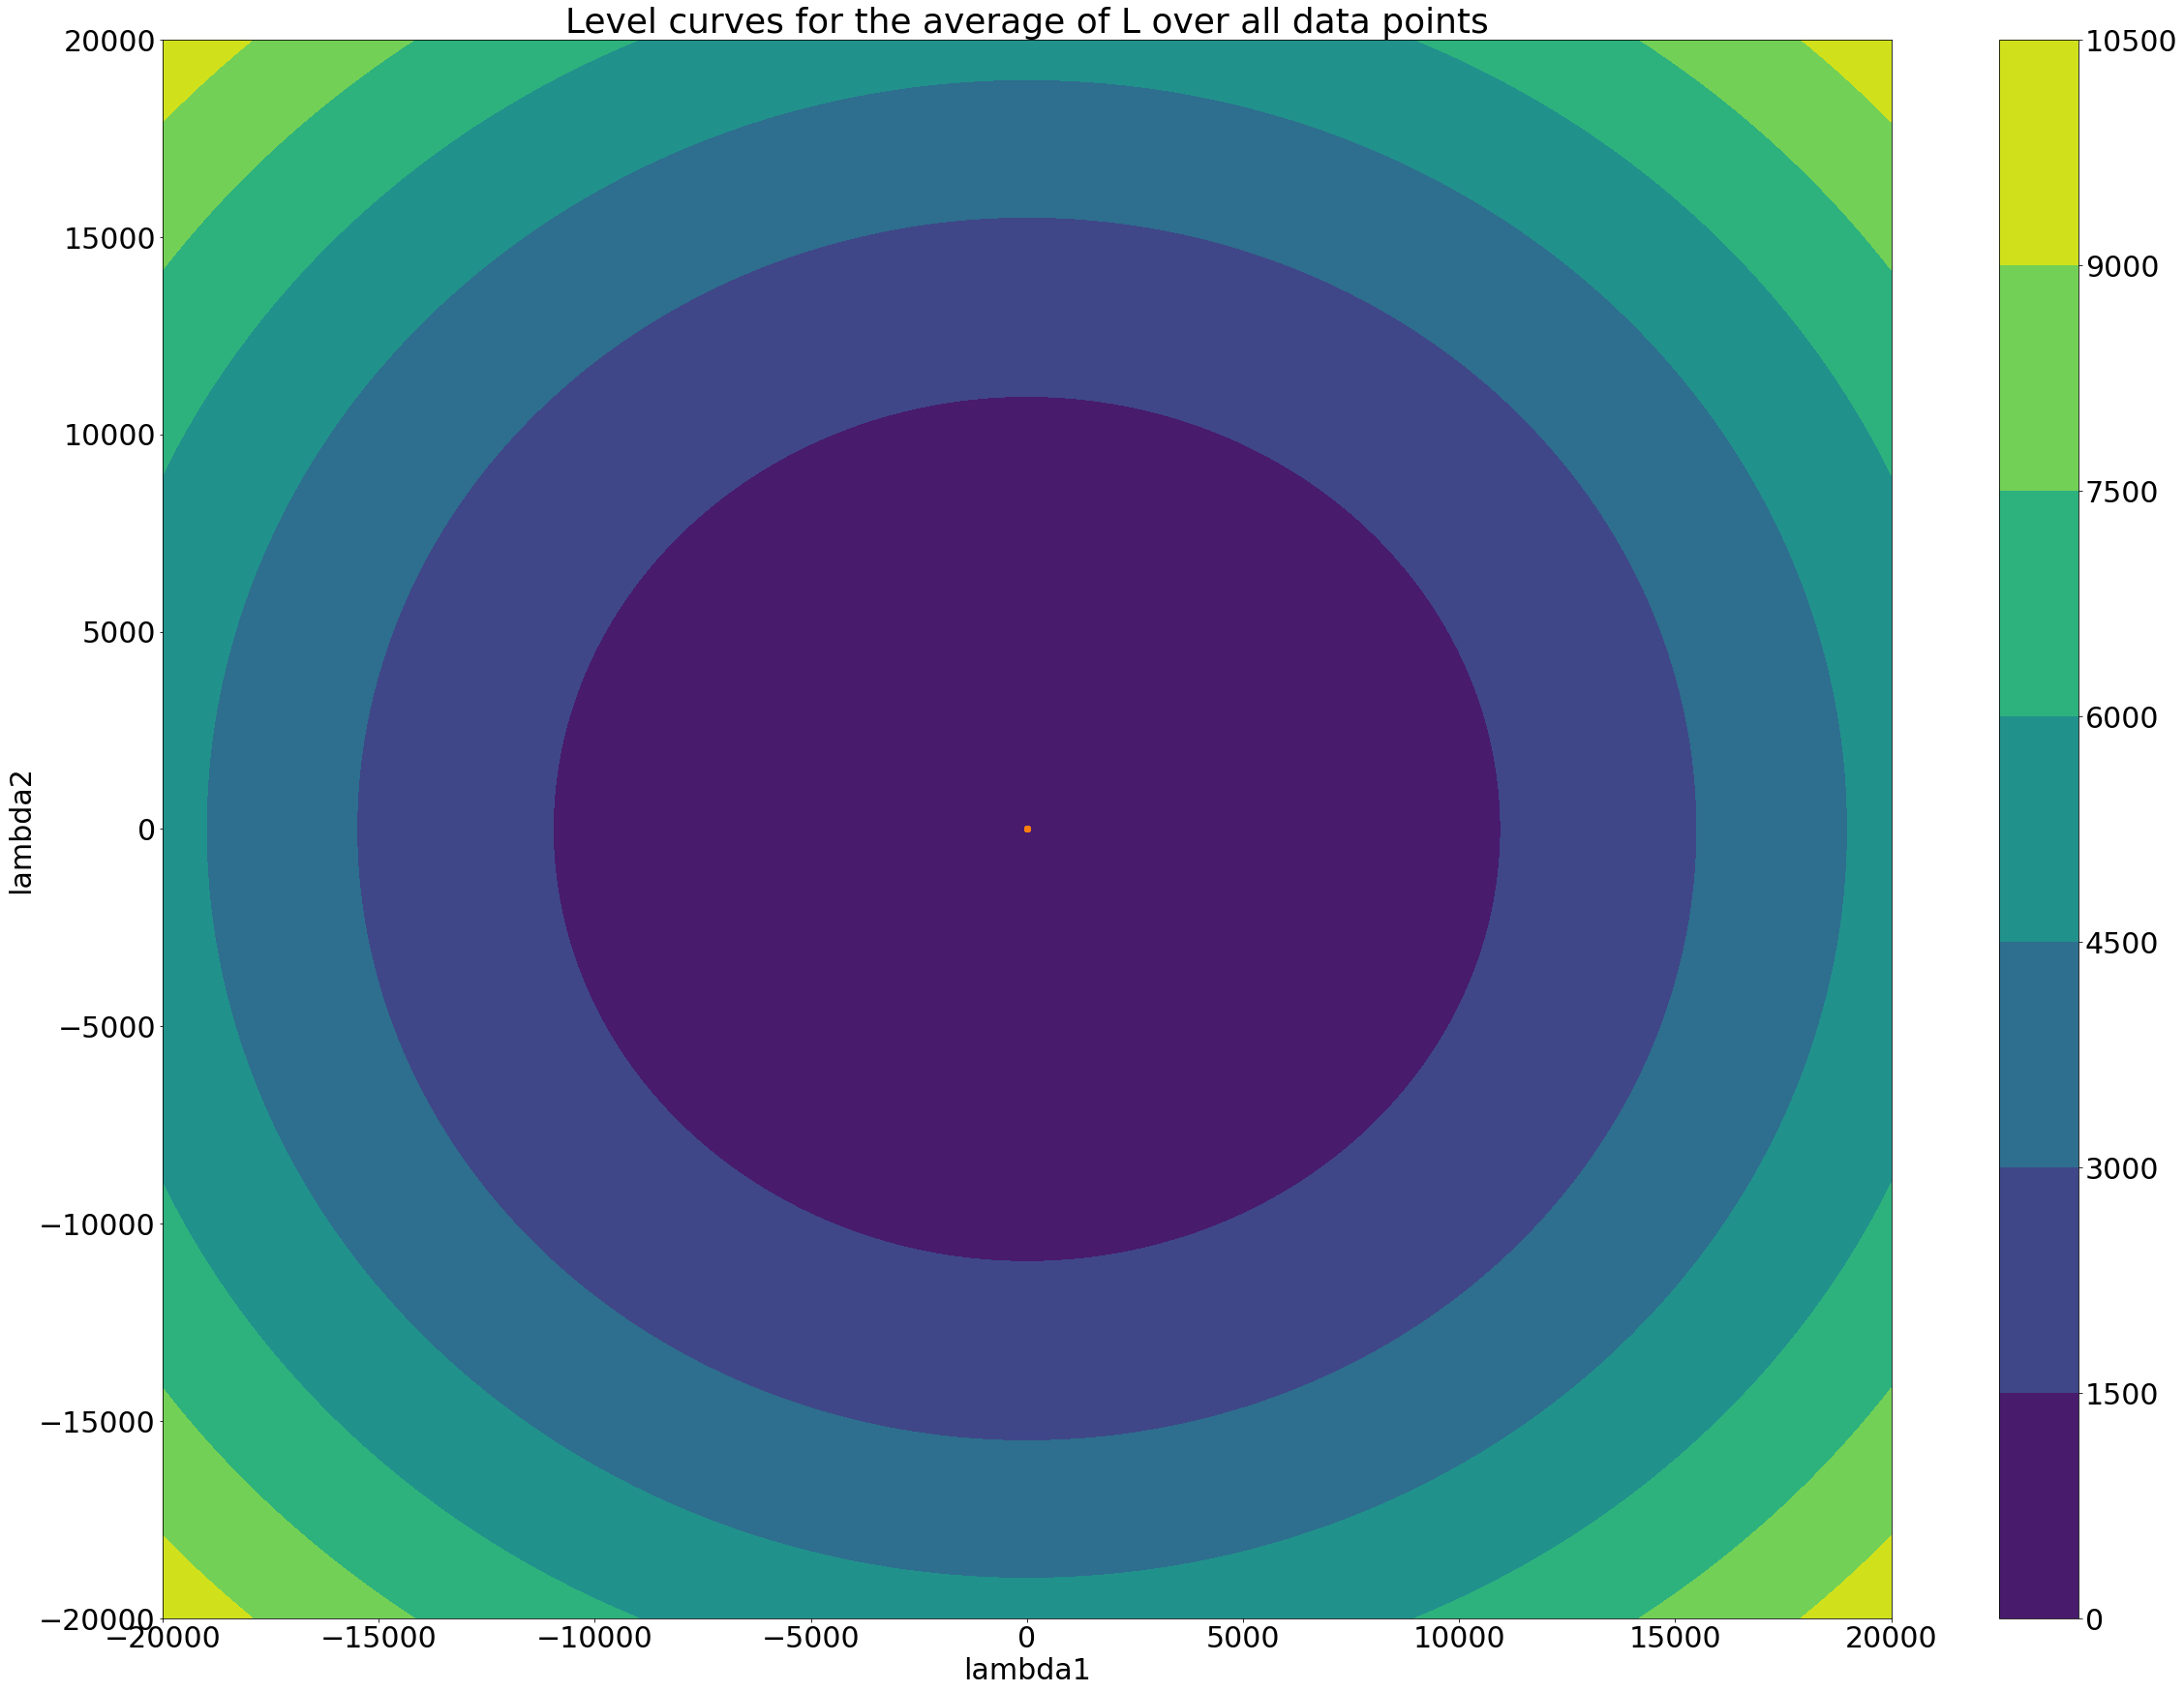

In [116]:
x_ax=np.linspace(-20000,20000,300)
y_ax=np.linspace(-20000,20000,300)
X_p, Y_p, Z_p=np.zeros((300,300)), np.zeros((300,300)), np.zeros((300,300))
for i in range(300):
    for j in range(300):
        Z_p[i][j]=L(x_ax[i],y_ax[j])
        X_p[i][j]=x_ax[i]
        Y_p[i][j]=y_ax[j]
fig,ax=plt.subplots(1,1)
fig.set_figheight(30)
fig.set_figwidth(40)
cp = ax.contourf(X_p,Y_p,Z_p)
fig.colorbar(cp) 
ax.set_title('Level curves for the average of L over all data points')
ax.set_xlabel('lambda1')
ax.set_ylabel('lambda2')
ax.scatter(2.05384,0)
ax.scatter(weights[:, 0], weights[:, 1])
plt.show()

### Part II: Simulated Annealing
1. Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our lost function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

  For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should feel free to set your own):

  - Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
  - Min Length: 500
  - Max Temperature: 10

  You should set your own cooling schedule.

First, a small recap on what simulated annealing is. We transform the objective function to minimize into a pdf. THerefore, the low points of our objective will be the high density regions for the pdf. One particularity we have seen for high density regions is that our MH algorithm tends to remain stuck in such regions. Therefore, we will implement a MH-like algorithm while using the transformed objective function as a pdf. 

Moreover, we will adjust a parameter $T$ over the iterations in order to control the tradeoff exploration vs exploitation. The physical intuition behind this parameter $T$ is that it represents the temperature: when the temperature is high, the system is in an excited state and particules are free. When the temperature is low, particules tend to remian sutck in their low-energy state, which will be the optima of our objective function to minimize.

This allow to combine the strenghts of MH with the robustness of SGD and adding the fact that we can control the trade-off exploration/exploitation.

Since the cooling schedule tends to accept less and less samples, we need to increase the number of proposed samples every time we decreast the temperature

In [130]:
def gibbs_pdf(lambda1, lambda2, T):
    return np.exp(-L(lambda1, lambda2)/T)

In [175]:
covariance_matrix = np.array([[1, 0], 
                              [0, 1]])
mean = [3, 1]
cooling_schedule = [np.abs(1000/x**2) for x in np.arange(2, 100)]
samples_size = 12*(np.arange(2, 100)) + 100
total_epochs = 98
number_of_samples = len(data)
iteration = 0
initial_parameter = [-5, 0]
accepted_samples = [initial_parameter]
for _ in itertools.repeat(None, total_epochs):
    print(iteration)
    for _ in itertools.repeat(None, int(samples_size[iteration])):
        accepted = False
        print('not yet')
        while accepted == False:
            proposition = np.random.multivariate_normal(mean=mean, cov=covariance_matrix)
            print(proposition)
            temperature = cooling_schedule[iteration]
            acceptance_probability = gibbs_pdf(*proposition, temperature)/gibbs_pdf(*accepted_samples[-1], temperature)
            U = np.random.uniform(0, 1)
            print(acceptance_probability)
            if U < acceptance_probability:
                accepted_samples.append(proposition)
                accepted = True
            else:
                accepted_samples.append(accepted_samples[-1])
    iteration += 1
    

0
not yet
[3.57382554 1.04060686]
1.000003165685371
not yet
[ 2.85506899 -0.33531496]
1.000000989785682
not yet
[ 0.85222855 -0.82220596]
0.9999993250430976
not yet
[1.72566421 1.03054684]
1.0000006911767407
not yet
[2.63484554 1.61955629]
0.9999994445678876
not yet
[3.47333676 1.51491476]
0.9999993885511586
not yet
[1.87001114 1.28425928]
1.000001042868558
not yet
[1.01280248 1.06855026]
0.9999995440590865
not yet
[2.9547753  2.57595552]
0.9999989812969705
not yet
[3.71500809 0.02072897]
1.0000006759272801
not yet
[2.74410047 0.92432505]
1.0000007745586406
not yet
[1.98911392 0.32193176]
1.0000004935882139
not yet
[4.28475338 0.01010855]
0.9999980019360111
not yet
[1.99312957 0.02563891]
1.0000020309704256
not yet
[3.86010633 1.69953806]
0.9999979343062771
not yet
[2.77605278 0.62997674]
1.0000016493264516
not yet
[3.63983569 3.04776401]
0.9999975745728032
not yet
[4.12593768 0.53056019]
1.0000009591432153
not yet
[2.98139729 1.33358339]
1.0000009211970637
not yet
[3.75220587 0.022396

not yet
[2.96380966 0.61559197]
1.0000057726610305
not yet
[2.98136054 2.25717577]
0.999997437498654
not yet
[2.15847396 0.35942298]
1.0000037366734553
not yet
[1.51771424 0.86161171]
0.9999992146881284
not yet
[2.85671362 1.44153796]
0.9999987730575881
not yet
[1.82614185 0.47083924]
1.000001891436299
not yet
[ 2.25260549 -0.39686893]
1.0000000609663018
not yet
[ 2.4858619  -0.38180128]
0.9999998124915517
not yet
[2.90531664 1.43040621]
0.9999981707329489
not yet
[3.06201492 2.28725114]
0.999998153580627
not yet
[2.79614534 0.83638709]
1.0000028549753854
not yet
[4.77840024 1.74499591]
0.9999942980196738
not yet
[1.82358199 1.33336495]
1.0000056432984286
not yet
[ 3.54605206 -0.36166434]
0.9999986988879158
not yet
[1.69087154e+00 7.12353115e-04]
1.000002344026382
not yet
[3.13885279 2.19674756]
0.9999962100805178
not yet
[ 3.82358337 -0.1615478 ]
1.0000007265565642
not yet
[2.76296831 1.18711649]
1.000001685000245
not yet
[1.97437858 1.00536894]
1.0000008693683375
not yet
[3.70193057 

0.9999932785440563
not yet
[3.13524525 0.17320376]
1.0000086641093946
not yet
[2.50789267 2.9196041 ]
0.9999942136809826
not yet
[3.89632098 1.65486124]
1.000000012897425
not yet
[3.65709151 0.24703688]
1.0000033355889943
not yet
[3.78614394 0.26280648]
0.9999993463329828
not yet
[3.56388113 2.70136328]
0.9999955679269411
not yet
[ 3.69671569 -1.29370079]
1.0000034502942063
not yet
[2.47597814 1.60521642]
1.000003238465993
not yet
[1.79760439 1.59401017]
1.0000003677312304
not yet
[ 2.91703406 -1.85369648]
0.9999977602965439
not yet
[4.5826666  0.81685268]
0.9999951902929873
not yet
[ 2.04334356 -0.64413113]
1.0000095411218988
not yet
[4.53131874e+00 1.71419004e-04]
0.9999911378347933
not yet
[4.04973806 1.23557237]
1.0000012635263602
not yet
[ 2.13941716 -0.83042674]
1.0000072417404913
not yet
[1.17836037 1.89289343]
0.9999956848706344
not yet
[3.52479518 1.02089726]
0.9999999044955575
not yet
[2.91826516 3.05064202]
0.9999957229905907
not yet
[2.45551957 0.65708188]
1.000008636265978

1.0000069985886155
not yet
[3.01645536 0.55574787]
0.9999984749195621
not yet
[2.53843504 2.60423248]
0.9999892653500037
not yet
[2.37636814 0.20573676]
1.0000154284876905
not yet
[3.31396231 1.95494577]
0.999985261423623
not yet
[2.29793517 0.61549692]
1.000014023622651
not yet
[ 2.83743631 -0.70328936]
0.9999969462575209
not yet
[1.98923641 1.57631831]
0.9999980162871577
not yet
[3.20169478 2.41782365]
0.9999883831289041
not yet
[3.07871097 1.06090735]
1.0000101372227497
not yet
[ 3.23827436 -0.15866177]
1.0000012236961624
not yet
[ 1.34402972 -1.97185488]
0.9999954788151552
not yet
[ 2.79222128 -2.03122417]
0.9999987688706112
not yet
[3.21237075 0.77711971]
1.0000045892256617
not yet
[ 3.89321148 -0.21305324]
0.9999940043302649
not yet
[2.80802379 0.36142514]
1.0000105822066288
not yet
[ 3.1406219  -0.30515231]
0.9999973392355096
not yet
[2.79348238 1.99718855]
0.9999937502757773
not yet
[3.99095219 3.77766339]
0.9999797720311843
not yet
[2.84614463 0.7695362 ]
1.0000276378836481
no

not yet
[ 2.78092919 -1.84762507]
0.9999907905202329
not yet
[3.35889565 1.2062849 ]
0.9999997043790018
not yet
[1.96412161 1.27389056]
1.0000092313312774
not yet
[1.16865007 0.58165526]
0.9999986382070203
not yet
[3.02184377 1.17741443]
0.9999963251326096
not yet
[4.02096398 0.53895003]
0.999989503055912
not yet
[1.78731737 0.98003216]
1.0000174287429997
not yet
[3.15163051 0.4780254 ]
0.9999953765188739
not yet
[2.2808778  2.11004701]
0.9999936376765686
not yet
[4.16819606 2.42112024]
0.9999804137194774
not yet
[1.34087508 0.84910725]
1.0000282080542071
not yet
[4.65779147 1.66986566]
0.9999708936924148
not yet
[3.17437233 1.67608892]
1.0000186683995587
not yet
[2.13712847 1.20545762]
1.000011437677333
not yet
[ 2.19948441 -0.6409242 ]
1.0000036775616565
not yet
[2.50115169 1.00935323]
0.9999964844117681
not yet
[2.6974878  0.08615291]
1.0000022888072821
not yet
[2.91323787 1.12691381]
0.9999934904540395
not yet
[2.05318438 1.7361622 ]
0.9999990541094499
not yet
[1.1893895  0.9944943

[0.89636289 2.60313198]
0.9999955155930303
not yet
[1.80462533 0.76961697]
1.0000288396861767
not yet
[1.06130308 1.31438928]
0.9999870250129658
not yet
[3.12782488 0.10111355]
1.0000065173032382
not yet
[ 2.51983605 -0.22162814]
1.0000076462808112
not yet
[4.20023588 0.85577238]
0.9999693107244204
not yet
[ 5.60226381 -0.13517894]
0.9999759473532072
not yet
[2.06735512 0.33444785]
1.0000564954855466
not yet
[2.63010561 0.26702637]
0.9999970950684386
not yet
[3.25628643 0.26597685]
0.999991048980596
not yet
[4.1002856 1.514616 ]
0.9999768461431308
not yet
[2.94330876 1.06790498]
1.000023351975412
not yet
[4.96412767 0.21862623]
0.9999662208025261
not yet
[2.67088767 1.79137108]
1.0000283952505278
not yet
[3.35767034 1.02797948]
0.9999993385965831
not yet
[1.70526266 1.54428099]
1.000006455208344
not yet
[2.33935557 1.10039645]
1.0000051165049806
not yet
[3.07669702 1.37089535]
0.9999895659437109
not yet
[2.13660544 1.00603501]
1.0000120918693327
not yet
[0.93598264 2.28858517]
0.999976

1.0000139347091161
not yet
[2.30680984 1.30656857]
1.0000353101181374
not yet
[3.24499812 2.35990245]
0.999970838579974
not yet
[2.36996746 1.01460717]
1.0000326680362839
not yet
[2.89896995 2.11871363]
0.9999766444872327
not yet
[ 2.77646495 -1.18160935]
1.0000167292487674
not yet
[ 4.12030019 -0.62228142]
0.9999758045217509
not yet
[3.54813679 0.54700053]
1.0000147324528188
not yet
[3.18228671 2.8767085 ]
0.9999752855525128
not yet
[4.26830294 2.27150506]
0.9999911943445527
not yet
[ 3.17224241 -0.96701439]
1.0000386037877378
not yet
[ 3.99726465 -1.33704468]
0.9999777782540764
not yet
[2.95481862 2.23618082]
1.0000069975857415
not yet
[ 1.89824391 -0.35383762]
1.0000327533369364
not yet
[2.70101957 2.82385795]
0.9999591376215887
not yet
[3.06021783 3.66373514]
0.9999813311626664
not yet
[3.35386977 1.38963134]
1.0000333851360999
not yet
[2.88898853 1.04248628]
1.0000129827522695
not yet
[4.03937293 0.33602256]
0.9999790129727144
not yet
[ 1.61480476 -0.69042474]
1.0000298947435047
n

[ 2.55247769 -0.00722253]
1.0000589152222068
not yet
[3.37228152 1.04961509]
0.9999744722161806
not yet
[ 2.73274504 -1.1997487 ]
1.0000120873709246
not yet
[ 3.52657419 -0.56014874]
0.9999884024945043
not yet
[ 1.85188902 -0.35643865]
1.0000270894324317
not yet
[3.84363498 2.06075576]
0.9999445021575631
not yet
[2.61678603 1.15208232]
1.0000426239057527
not yet
[3.01472376 0.6488702 ]
0.9999988034650081
not yet
[3.22775283 0.25682896]
0.9999971074877511
not yet
[2.10063465 2.97443552]
0.9999678589824078
not yet
[2.27695034 2.18537546]
1.0000182784332363
not yet
[ 3.55129352 -0.83923803]
1.0000006510472446
not yet
[5.72286527 1.15863161]
0.9999366407889763
not yet
[ 3.01687323 -0.34938537]
1.0000815588116714
not yet
[2.5659575  0.92224843]
1.0000032610792196
not yet
[3.60421015 0.50448467]
0.9999796723587483
not yet
[1.26263832 0.75045654]
1.0000167942280567
not yet
[3.93359498 0.36006731]
0.9999736555573293
not yet
[3.50458374 0.60683134]
1.0000118224034262
not yet
[1.40122255 0.23921

0.9999717513613414
not yet
[ 3.52446028 -0.81512296]
1.00001465747102
not yet
[3.64820981 3.8567231 ]
0.9999327600914782
not yet
[4.13902712 0.78095242]
1.0000450761254231
not yet
[3.39395819 1.96374649]
1.0000052246994917
not yet
[3.05782866 2.62409098]
0.9999910486024943
not yet
[ 4.81123557 -0.28477004]
0.9999814842298828
not yet
[4.51027117 1.30786662]
1.0000033283355017
not yet
[2.38098215 2.00028255]
1.0000433971621399
not yet
[3.46935625 0.58831412]
1.0000019820218655
not yet
[2.495951   1.67034644]
1.0000055036486777
not yet
[ 3.1561975 -0.3513895]
1.0000067714792562
not yet
[2.69690297 1.14495755]
1.0000017680318818
not yet
[ 3.93171873 -0.35534993]
0.9999703356519586
not yet
[3.82180704 0.98497759]
0.999998653154837
not yet
[2.58938854 0.20574308]
1.0000444195996316
not yet
[4.45370316 0.40333989]
0.999936675457253
not yet
[ 2.48434131 -0.88385417]
1.0000582202279413
not yet
[3.37476769 0.17102303]
0.9999834469752626
not yet
[2.30941913 0.31361537]
1.0000250262170018
not yet


0.9999963986087506
not yet
[2.91871705 2.33360513]
0.9999625568323095
not yet
[2.98642673 1.72163091]
1.0000172652407804
not yet
[4.331321   0.58585203]
0.9999676582554368
not yet
[1.71012971 2.46029783]
1.0000222078662728
not yet
[4.09230032 2.13995267]
0.9999625559174193
not yet
[ 1.73631066 -0.54244433]
1.0000872622636197
not yet
[4.10345899 1.67726591]
0.9999222348846718
not yet
[3.48466605 1.34761989]
1.0000309553309796
not yet
[3.67353737 1.65369935]
0.9999859822955501
not yet
[2.06570527 0.26489117]
1.000065581127132
not yet
[3.28280228 2.43873744]
0.9999257316684027
not yet
[3.73067345 1.30961316]
1.0000138348213017
not yet
[3.52528897 2.23414345]
0.9999849960461961
not yet
[ 3.18807381 -1.23698039]
1.0000371121686955
not yet
[4.23298368 1.45196059]
0.9999548765977089
not yet
[1.84474899 1.36452523]
1.0000638497461145
not yet
[4.39945818 0.35798878]
0.9999411342106531
not yet
[1.84878494 0.04245238]
1.0000782928257794
not yet
[4.81410529 2.43213979]
0.9998782043715084
not yet
[

1.0000071516530877
not yet
[2.55829004 1.73624879]
0.9999862873385428
not yet
[3.75090854 1.47465807]
0.9999652406765728
not yet
[ 1.25197787 -0.54757379]
1.0000556518478096
not yet
[1.70350855 0.08099813]
1.0000176507072194
not yet
[ 2.72096625 -1.0689782 ]
0.9999783060457474
not yet
[3.70357586 2.24869705]
0.9999284918299441
not yet
[4.31396799 0.32824301]
1.0000083177571415
not yet
[3.35342112 0.80554429]
1.0000445685923014
not yet
[ 4.83435925 -1.13195377]
0.999921553510965
not yet
[2.24554252 0.30639396]
1.000119988640145
not yet
[4.02880883 1.35885164]
0.9999150101336243
not yet
[3.80956434 1.23455695]
1.000013220754321
not yet
[ 3.79202581 -0.18332461]
1.0000144924208891
not yet
[ 2.81416697 -0.47714822]
1.0000426880420397
not yet
[4.40578019 0.91190249]
0.9999183766203024
not yet
[2.87736477 0.11652582]
1.0000821314629351
not yet
[2.28866555 0.56767362]
1.000010575393748
not yet
[ 3.28624058 -0.1120937 ]
0.9999722034746243
not yet
[5.07704373 1.61747016]
0.9998938129200132
not 

0.9999579533438908
not yet
[1.68228252 2.14327   ]
1.0000070884039698
not yet
[3.24138704 1.87723394]
0.9999857373246827
not yet
[4.16700334 0.45173843]
0.9999859768861733
not yet
[1.90846627 2.38006269]
1.000020234159194
not yet
[3.54059629 0.9307472 ]
1.0000061031080572
not yet
[3.67007418 0.89317398]
0.9999943111328662
not yet
[2.29664911 2.63724796]
0.9999869609506479
not yet
[ 5.05354801 -0.28066392]
0.9999475940385579
not yet
[3.00366336 1.55218535]
1.000077892235802
not yet
[ 3.48513956 -2.75706102]
0.9999424105802737
not yet
[2.11799638 2.48359887]
1.0000399796180115
not yet
[4.14394945 2.00184027]
0.9999582445854267
not yet
[0.67469267 0.72506573]
1.0000521779043572
not yet
[2.696789   1.24348792]
1.0000261253083456
not yet
[3.53289362 2.22779558]
0.9999396290077883
12
not yet
[ 2.94194714 -0.05916821]
1.0000822913159046
not yet
[ 3.99379011 -0.21111601]
0.9999398233918139
not yet
[4.01319924 2.96732522]
0.9999316973358753
not yet
[2.0578389 1.4323496]
1.0001205564021671
not y

1.0000644670116867
not yet
[2.80102063 0.18183988]
1.0000526205355296
not yet
[3.18726972 0.58619845]
0.9999780149330405
not yet
[4.3038878  1.72871857]
0.999912860448551
not yet
[3.82062505 0.93984153]
1.0000453114247094
not yet
[2.88499989 3.03717772]
0.9999642105860334
not yet
[3.55601732 0.01999946]
1.0000615028286128
not yet
[2.02768206 0.18055125]
1.0000536960675332
not yet
[2.78511079 1.18574826]
0.9999656028742724
not yet
[3.49379991 2.781398  ]
0.999911053392686
not yet
[ 3.2023977  -0.23998082]
1.0000888609593817
not yet
[3.21053778 2.45245246]
0.9999349104811682
not yet
[2.43785783 0.35692913]
1.0000937736579898
not yet
[2.43236676 0.56133574]
0.9999972386970891
not yet
[2.86296052 3.10431625]
0.9998909462657214
not yet
[2.69645729 0.5475215 ]
1.0001019064452354
not yet
[4.42212251 1.44094736]
0.9998914800281924
not yet
[2.32586672 1.52806028]
1.0000892242747415
not yet
[4.5490912 1.2635016]
0.9999073326318395
not yet
[2.29640696 1.25528649]
1.0001032543577892
not yet
[2.854

[1.66922327 0.73661516]
1.000040383290644
not yet
[2.89909397 1.50705179]
0.9999568919702722
not yet
[ 3.22434494 -0.34677767]
1.0000150329917379
not yet
[3.06662815 2.92722262]
0.9999095153436046
not yet
[ 3.0997316  -0.81799289]
1.0000892158467831
not yet
[ 2.24636617 -1.75462302]
0.9999934106174865
not yet
[2.3631275  1.89143772]
0.999991294888436
not yet
[ 3.68007262 -0.41353688]
0.9999859225772744
not yet
[2.56907807 0.41775812]
1.0000612297534612
not yet
[2.93273941 0.68618249]
0.999979935244174
not yet
[2.41779451 0.81340399]
1.0000159141424645
not yet
[3.19253322 1.55860438]
0.9999425937987944
not yet
[ 2.66613197 -0.06073259]
1.0000611069708956
not yet
[2.42615477 0.51306757]
1.000002986962496
not yet
[2.2740647  3.01571755]
0.999891064539506
not yet
[3.75362699 1.2467598 ]
1.0000230490400204
not yet
[ 2.87570757 -0.05237429]
1.000073820293997
not yet
[5.15708621 0.70945735]
0.9998442854717189
not yet
[3.1528684  0.96762456]
1.0001264917153858
not yet
[2.36006951 1.17196052]
1

1.0000241102532712
not yet
[3.30043687 1.95653535]
0.9999904867372189
not yet
[1.87285324 1.31877485]
1.0000752045620624
not yet
[ 2.09330108 -1.14219939]
1.0000084711822335
not yet
[2.24515597 2.05507867]
0.9999506291930615
not yet
[3.80296969 0.11107768]
0.9999840286946725
not yet
[ 2.7363713  -0.55469865]
1.0000675084998676
not yet
[3.25468493 3.46131419]
0.9998357360444593
not yet
[2.92139948 0.08234383]
1.0001604417294967
not yet
[1.8580694 0.6496027]
1.0000171835215055
not yet
[4.02742851 0.17993816]
0.9999004966233892
not yet
[2.90314097 0.0945303 ]
1.0000833232335335
not yet
[1.43316746 0.25833366]
1.000008743128138
not yet
[1.50576407 2.0282891 ]
0.9999398131651518
not yet
[3.43078517e+00 6.17819148e-04]
1.0000163052046591
not yet
[3.62465894 1.83440513]
0.9999386094998883
not yet
[3.48743137 0.15996191]
1.0000566693080746
not yet
[ 2.80618286 -0.30803773]
1.0000434181643916
not yet
[2.96490422 0.67513164]
0.9999845721289405
not yet
[2.6215205  2.04027883]
0.9999550470505524
n

not yet
[ 0.85640273 -0.43741289]
1.0000307806452673
not yet
[3.61188925 1.6683836 ]
0.99994738789635
not yet
[2.85490588 0.99397937]
1.0000729643868722
not yet
[0.85236132 0.97128214]
0.9999696566367358
not yet
[ 2.91135061 -0.11226195]
1.0000453535929903
not yet
[4.28122555 1.55979585]
0.9998700505703674
not yet
[4.02579705 1.15973   ]
1.0000306166312927
not yet
[1.37710736 0.10948736]
1.0001065576559294
not yet
[1.75237703 3.39777957]
0.9998657599570371
not yet
[3.27268156 0.89753897]
1.0000903360461708
not yet
[2.31257071 0.82167824]
1.0000472034046604
not yet
[4.17922    0.33679567]
0.9998932249608952
not yet
[3.46793973 0.22973157]
1.000057994516741
not yet
[2.99334032 3.18469949]
0.9999016368498075
not yet
[3.64330127 1.00203882]
1.0000705517719646
not yet
[4.83180436 0.8371006 ]
0.9999127804229002
not yet
[ 3.93841598 -0.31344006]
1.000076956975381
not yet
[3.91200193 0.05656766]
1.000003484197456
not yet
[2.87182966 0.16010376]
1.0000748501063368
not yet
[1.48683034 0.50454543

0.999964946715818
not yet
[2.67995432 2.85972872]
0.9999228007900746
not yet
[2.0892776  2.18471546]
1.0000601594197998
not yet
[1.38525568 1.2049021 ]
1.0000426392721578
not yet
[ 4.66967731 -1.22295064]
0.9998508649597176
not yet
[4.83963372 2.44131898]
0.9999494581130172
not yet
[4.06548092 2.09690517]
1.000065952237077
not yet
[1.31352395 0.90527749]
1.0001409941719301
not yet
[2.86719623 0.40170575]
1.000010968947027
not yet
[2.08443146 1.80075303]
0.9999647189612497
not yet
[3.79879318 0.79783481]
0.9999536443026108
not yet
[3.7097463  0.89919124]
1.0000049885937965
not yet
[3.83820765 1.0582497 ]
0.9999841708228858
not yet
[3.18417844 0.40243169]
1.0000706272309454
not yet
[3.1635183  0.65717506]
0.9999961843181571
not yet
[ 3.83169839 -0.86222562]
0.9999394807151472
not yet
[3.03520516 0.95830936]
1.000059953292533
not yet
[2.23631388 1.13081535]
1.0000270944750738
not yet
[2.07825389 0.28370322]
1.0000277476210488
not yet
[3.09296006 1.99554773]
0.9998888836406453
not yet
[3.2

1.0001937510621497
not yet
[3.05820472 2.7512218 ]
0.9998672574118576
not yet
[ 3.47643378 -0.30489254]
1.0000946032413172
not yet
[4.23263167 2.01627008]
0.9998698619174056
not yet
[3.2705314  1.62874983]
1.0000982280990496
not yet
[3.9505689  0.62258749]
0.9999791461465252
not yet
[2.51759793 1.50641461]
1.0000730503412663
not yet
[1.88156923 0.75096831]
1.0000479627472016
not yet
[3.83298408 0.02408572]
0.9998978612725534
not yet
[3.6372826  0.74945463]
1.0000091288574608
not yet
[2.70877044 0.87477743]
1.0000698044813197
not yet
[2.03873723 2.24457341]
0.9999321128813567
not yet
[1.4565849 0.2294064]
1.0000865626865303
not yet
[1.41526792 1.63646655]
0.9999435737222806
not yet
[3.05694064 1.2464398 ]
0.9999978171555415
not yet
[3.4458978  1.75162685]
0.999942396359725
not yet
[ 3.12934278 -0.16314501]
1.0000853437246713
not yet
[3.62349138 0.12430194]
0.9999543265697721
not yet
[3.74452268 0.55502476]
0.999982277523902
not yet
[4.41251373 0.32480998]
0.9999349780822238
not yet
[3.5

[3.61968358 0.37925849]
1.0000079490796734
not yet
[3.15492171 1.57930208]
0.9999944981562863
not yet
[ 2.69267025 -0.19865065]
1.0000840930667583
not yet
[2.38451457 1.96942647]
0.9999288057147511
not yet
[4.48441155 1.3790628 ]
0.999881637028334
not yet
[ 3.36808024 -0.66583095]
1.0001288327168918
not yet
[3.89709076 1.63540933]
0.9999133700858851
not yet
[1.38699523 3.14339059]
0.9999876905078972
not yet
[4.42913811 0.37797772]
0.9999982885990762
not yet
[3.12774069 1.08806387]
1.0001053323561622
not yet
[2.75213492 0.47841192]
1.000047883759999
not yet
[1.34291495 1.7189698 ]
0.9999431760295476
not yet
[2.58028944 0.32896272]
1.0000691957889127
not yet
[3.24241202 0.38977019]
0.9999525450644627
not yet
[1.58649212 1.10590322]
1.000024021876777
not yet
[ 4.21747312 -0.38796225]
0.9998794164034469
not yet
[3.17867211 1.92111077]
1.000032727182837
not yet
[3.88817878 0.80847591]
0.9999924988130604
not yet
[ 4.13509687 -0.37495835]
0.999983432815674
not yet
[4.25315674 1.0014176 ]
0.99

1.0001424319973944
not yet
[2.02670605 1.87094311]
1.000031703631723
not yet
[1.6347523  1.48623676]
1.0000224491832301
not yet
[4.11379374 0.73923483]
0.9998916014981932
not yet
[2.11829636 1.06000883]
1.0001421900274723
not yet
[ 4.91338747 -0.35656915]
0.9997761079972723
not yet
[3.16329939 0.6770458 ]
1.0001844044053771
not yet
[2.57115719 1.05161892]
1.0000263952638284
not yet
[ 3.81657461 -1.2013843 ]
0.9998870673182281
not yet
[2.856186   0.78293306]
1.0001081377229244
not yet
[4.57233336 0.91687363]
0.9998208704622191
not yet
[ 1.70990126 -0.02986286]
1.0002214224291694
not yet
[2.58049543 0.43211392]
0.9999868558523696
not yet
[2.50396502 0.41414198]
1.0000042601584094
not yet
[1.55279466 1.03010219]
0.9999740992462162
not yet
[4.47288072 1.06006507]
0.9998199754470466
not yet
[2.73695896 3.30368424]
0.9999931029213522
not yet
[3.21639683 1.7805794 ]
1.000093896144556
not yet
[2.24962621 1.26317774]
1.000089335468512
not yet
[1.17334737 0.86049766]
0.9999831398250264
not yet
[

0.9999579569020565
not yet
[3.96388464 3.01741558]
0.9998147097792784
not yet
[3.37779202 0.73801978]
1.0001826523903707
not yet
[ 3.12424009 -0.25183434]
1.000036253249322
not yet
[ 2.6615438  -0.38719426]
1.0000335925604722
not yet
[3.00457447 0.09136267]
0.9999785324248908

KeyboardInterrupt: 